# 1. Imports

In [115]:
import time
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, log_loss
from catboost import CatBoostClassifier
import warnings


plt.rcdefaults()
plt.rcParams['figure.figsize'] = [12, 12]
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [77]:
def create_predictions(probab_array):
    return np.where(probab_array.mean(axis=1) > 0.5, 1, 0)

# 2. Load Data

In [4]:
cols = pd.read_csv('data/census-bureau.columns', header=None)[0].str.replace(' ', '_', regex=True).tolist()
df = pd.read_csv('data/census-bureau.data',names=cols)
df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [5]:
def create_numeric_label(label):
    if label == '- 50000.':
        return 0
    return 1
df.label = df.label.apply(create_numeric_label)
x = df.drop(columns=['label']).copy()
y = pd.DataFrame(df['label'])

# 3. Initial Data Exploration

## 3.1 Numerical Features

In [6]:
cols = x.columns
num_cols = x._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

In [7]:
x.dtypes.value_counts()

object     28
int64      12
float64     1
dtype: int64

We have 28 categorical columns and 13 numerical columns

In [8]:
# Creating a plot to find correlation between numeric columns in training data
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,detailed_industry_recode,detailed_occupation_recode,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,weight,num_persons_worked_for_employer,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,label
age,1.000000,0.157822,0.117414,0.036938,0.053590,0.063351,0.104976,-0.001611,0.140887,-0.002265,0.674844,0.206181,0.004413,0.135720
detailed_industry_recode,0.157822,1.000000,0.563493,0.165980,0.066017,0.072586,0.012774,0.029388,0.642096,0.252694,0.476475,0.754472,0.003430,0.196190
detailed_occupation_recode,0.117414,0.563493,1.000000,0.194498,0.002534,0.043680,-0.026726,0.027047,0.515554,0.228952,0.438680,0.655613,-0.003140,0.013414
wage_per_hour,0.036938,0.165980,0.194498,1.000000,-0.001082,0.010993,-0.005731,0.012353,0.191543,0.054051,0.113094,0.195687,0.002283,0.024528
capital_gains,0.053590,0.066017,0.002534,-0.001082,1.000000,-0.012700,0.131476,0.002549,0.058015,0.015048,0.051530,0.083549,0.005243,0.240725
capital_losses,0.063351,0.072586,0.043680,0.010993,-0.012700,1.000000,0.042427,0.008052,0.084255,0.024116,0.075391,0.100762,0.000096,0.147417
dividends_from_stocks,0.104976,0.012774,-0.026726,-0.005731,0.131476,0.042427,1.000000,-0.000009,0.007206,-0.004885,0.054585,0.013823,0.001913,0.175779
weight,-0.001611,0.029388,0.027047,0.012353,0.002549,0.008052,-0.000009,1.000000,0.042778,0.012328,0.040507,0.029240,0.011765,0.014463
num_persons_worked_for_employer,0.140887,0.642096,0.515554,0.191543,0.058015,0.084255,0.007206,0.042778,1.000000,0.240553,0.463334,0.747302,0.018774,0.222684
own_business_or_self_employed,-0.002265,0.252694,0.228952,0.054051,0.015048,0.024116,-0.004885,0.012328,0.240553,1.000000,0.177448,0.265872,0.007377,0.040473


There is no direct correlation between the label and other numerical parameters

In [9]:
print('Highly Correlated Features:')
used_pairs = []
for col in corr.columns:
    for ind in corr.index:
        if corr.loc[ind,col] >= 0.6 and corr.loc[ind,col] != 1:
            if ind+col in used_pairs or col+ind in used_pairs:
                continue
            used_pairs.append(ind+col)
            print('Correlation between',col, 'and', ind, 'is', corr.loc[ind,col])

Highly Correlated Features:
Correlation between age and veterans_benefits is 0.674844248178521
Correlation between detailed_industry_recode and num_persons_worked_for_employer is 0.6420963641262052
Correlation between detailed_industry_recode and weeks_worked_in_year is 0.7544724182245167
Correlation between detailed_occupation_recode and weeks_worked_in_year is 0.6556127967378161
Correlation between num_persons_worked_for_employer and weeks_worked_in_year is 0.74730161663203


For our purposes we will assume that correlation coeff > 0.7 is considered strong and will exclude such parameters so that we dont duplicate the signal

In [10]:
cols_to_drop = ['detailed_industry_recode','num_persons_worked_for_employer']

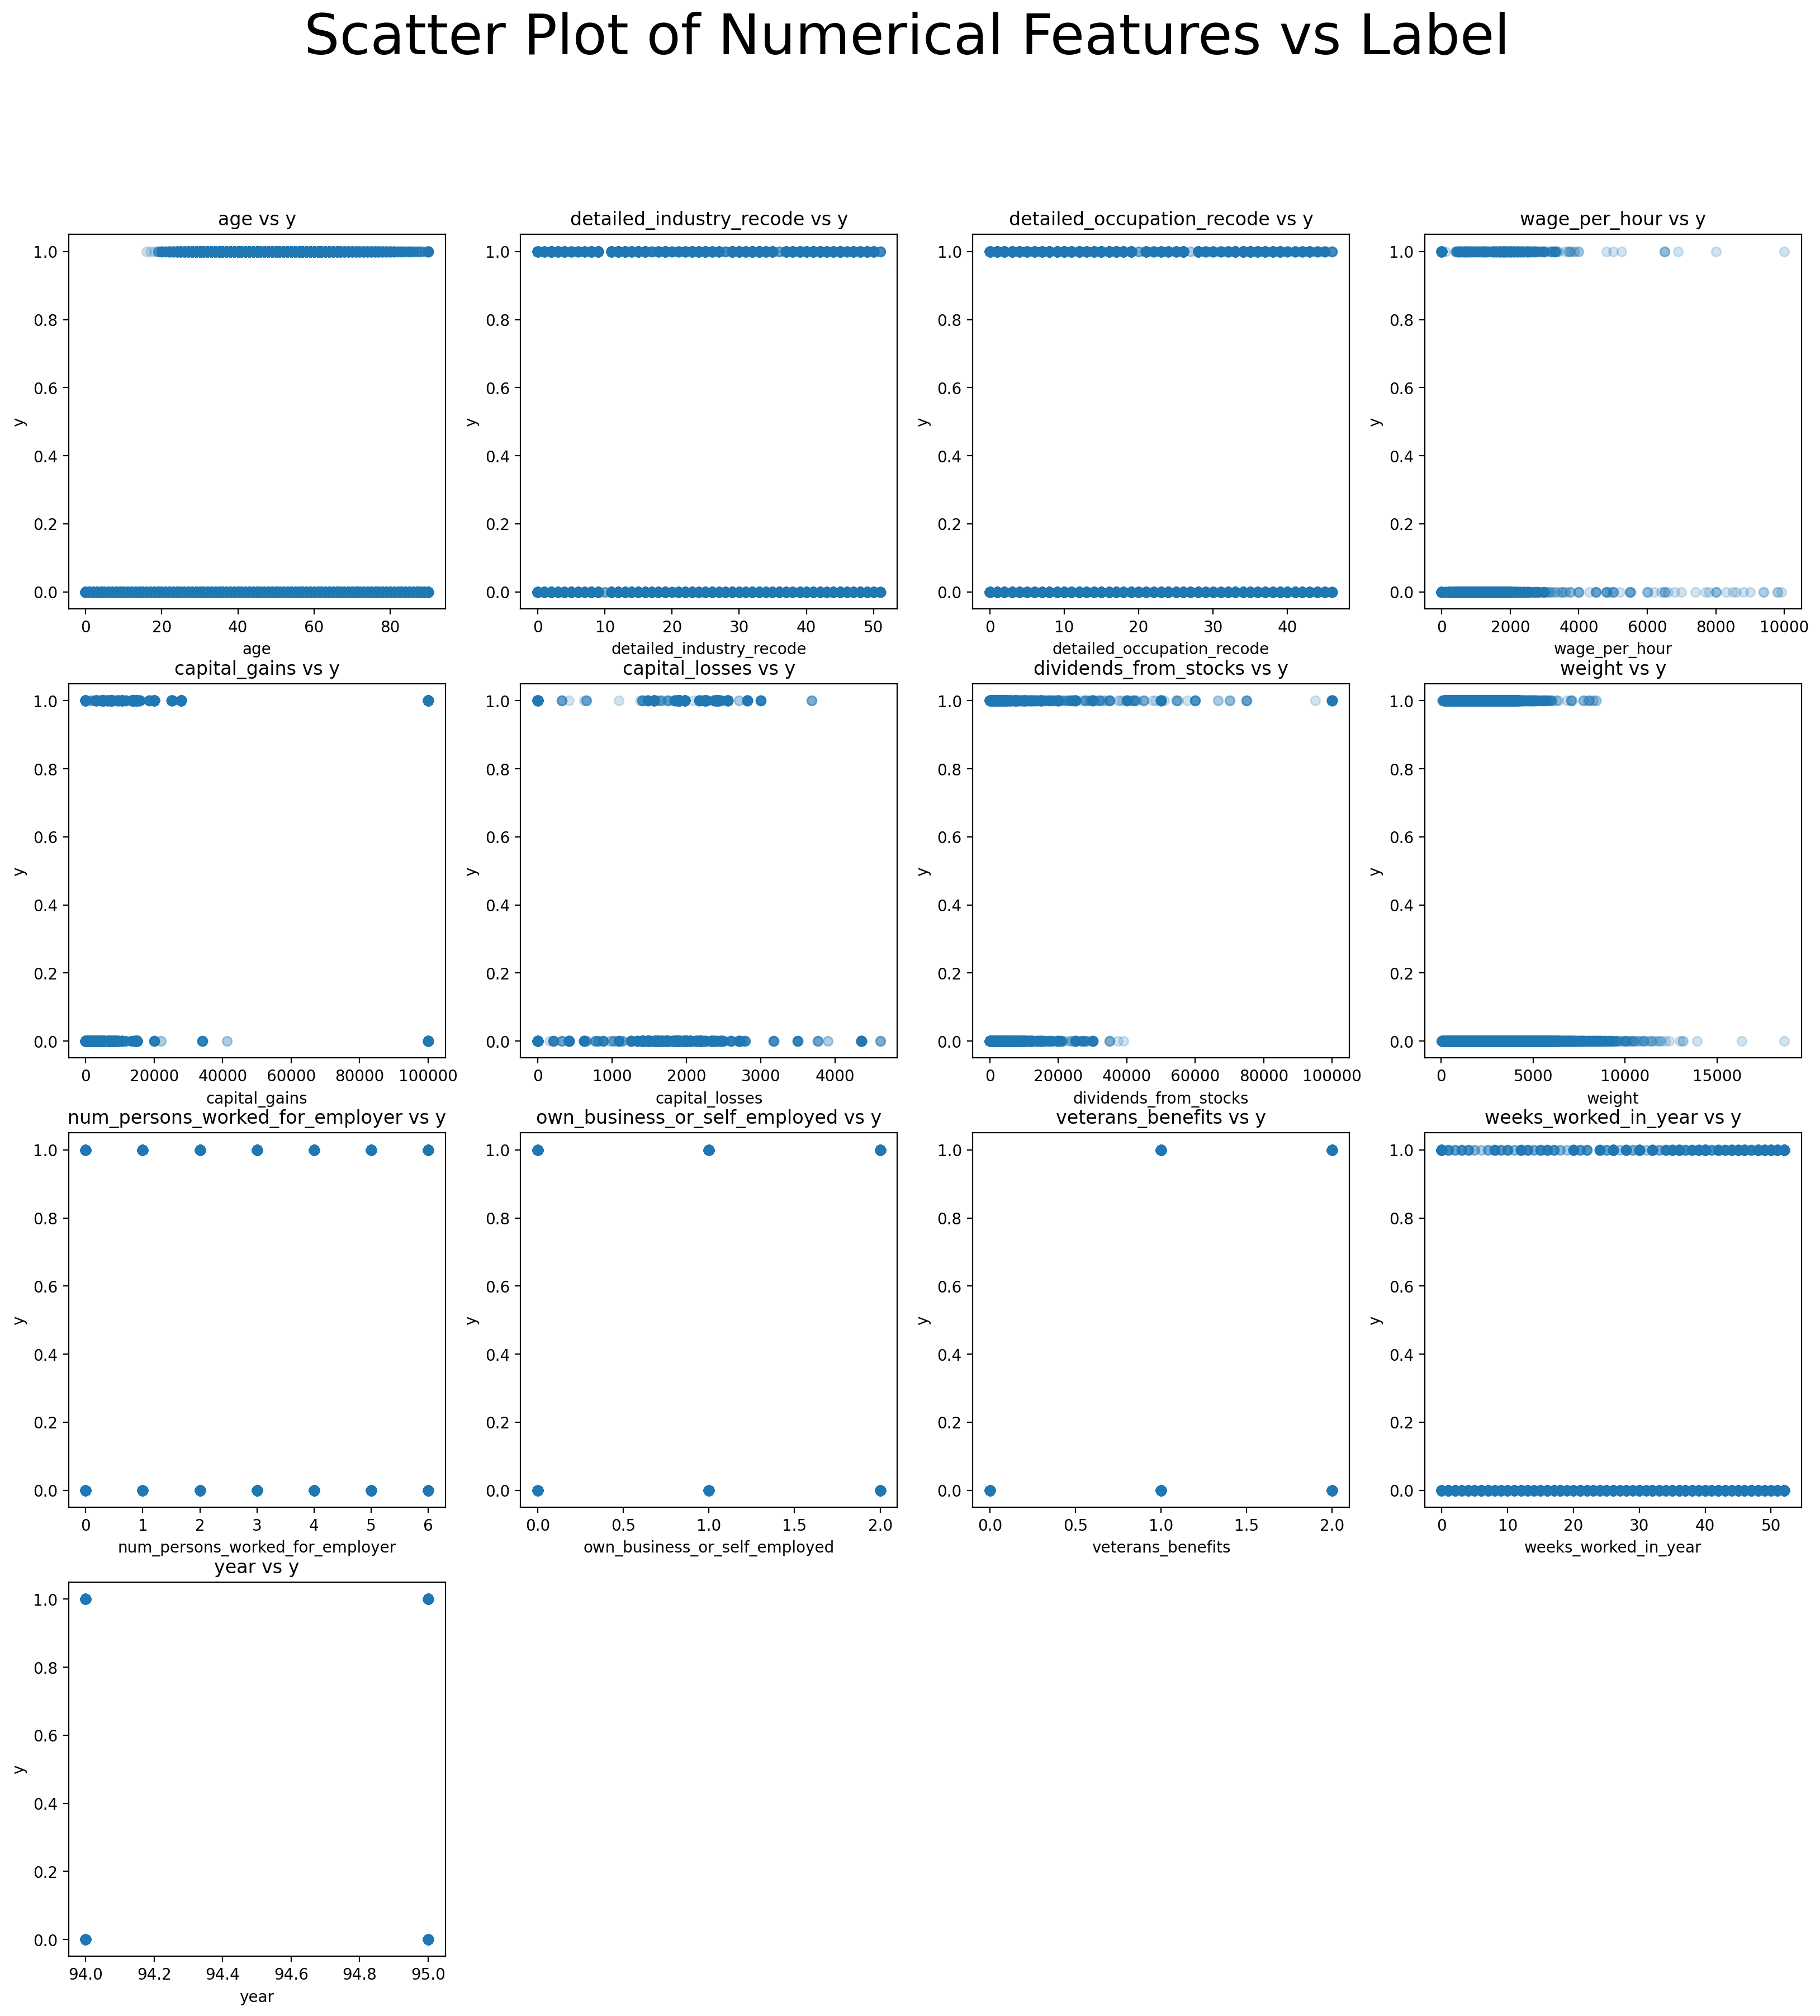

In [11]:
fig, axs = plt.subplots(4,4,figsize=(20,20))
fig.suptitle('Scatter Plot of Numerical Features vs Label',fontsize=36)
axs = axs.flatten()

for i in range(len(num_cols)):
    c = num_cols[i]
    axs[i].scatter(x[c],y,alpha=0.2)
    axs[i].set_xlabel(c)
    axs[i].set_ylabel('y')
    axs[i].set_title(f'{c} vs y')

axs[13].set_visible(False)
axs[14].set_visible(False)
axs[15].set_visible(False)

plt.show()

No clear linear relationship between the features and the label

## 3.2 Categorical Columns

In [ ]:
# fig, axs = plt.subplots(4,7,figsize=(28,16))
# fig.suptitle('Bar Plot of Categorical Features vs Label',fontsize=36)
# axs = axs.flatten()

# for i in range(len(cat_cols)):
#     c = cat_cols[i]
#     axs[i].bar(x[c],y)
#     axs[i].set_xlabel(c)
#     axs[i].set_ylabel('y')
#     axs[i].set_title(f'{c} vs y')

# fig.show()

This code was not run due to lack of computation power on my end. The code kept crashing my system but the idea behind this is to check if there is a difference in distribution between the label and categorical feature i.e. some values resulting having a higher distribution of a particular target label. This will be the motivation behind using or skipping target encoder later on. If the distribution was similar, target encoder would return similar values for each category within a column and make it irrelevant for our use. 

This step can also be used to remove columns that would not have a significant impact on the predictions. 

## 3.3 Dataset imbalance

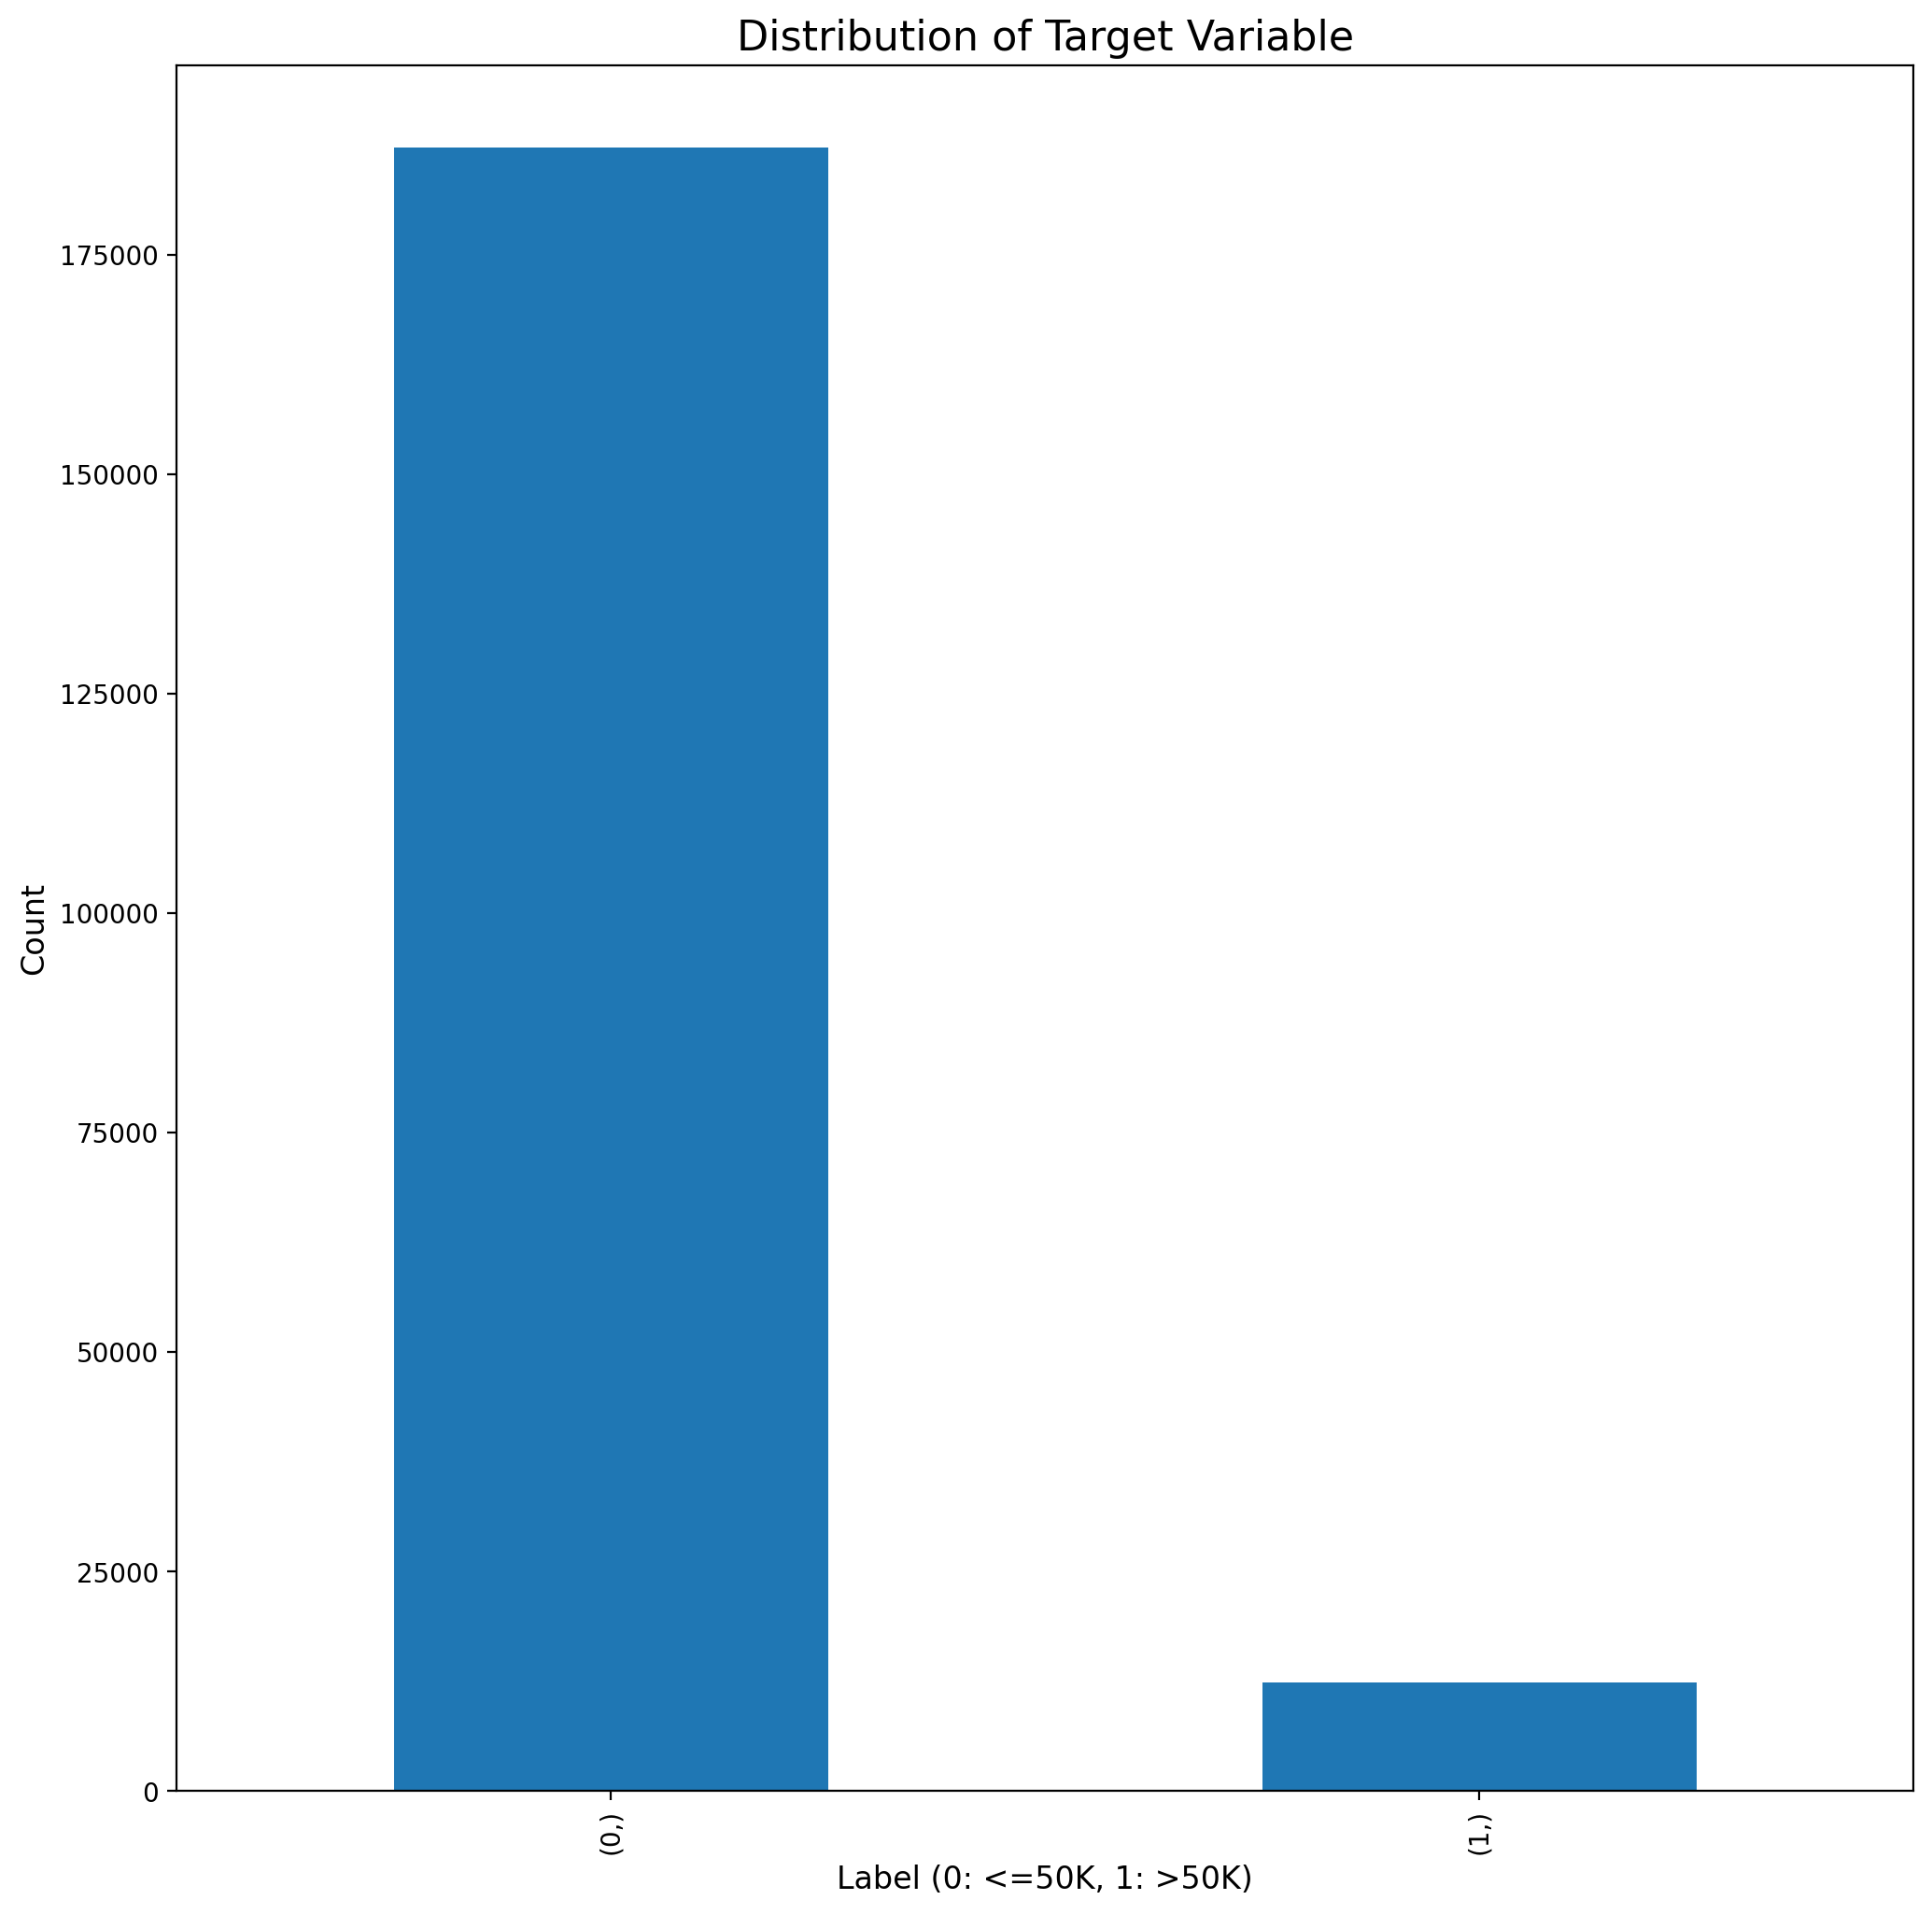

In [12]:
y.value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable',size = 16)
plt.xlabel('Label (0: <=50K, 1: >50K)',size = 12)
plt.ylabel('Count',size = 12)
plt.show()

We have a highly imbalanced dataset, we will need to account for this in data preprocessing steps

# 4. Data Preprocessing

## 4.1 Data Cleaning

In [13]:
x = x.drop(columns=['detailed_industry_recode','num_persons_worked_for_employer'])

In [14]:
x_dev, x_test, y_dev, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_dev,y_dev,test_size=0.25,random_state=42,stratify=y_dev)

In [15]:
missing_data = pd.DataFrame(df.isnull().sum(), columns=['missing_cnt']).reset_index()
missing_data.columns = ['col_name', 'missing_cnt']
missing_data['percentage'] = (missing_data['missing_cnt'] / len(df)) * 100
missing_data.sort_values(by='missing_cnt', ascending=False, inplace=True)
missing_data.head()

,col_name,missing_cnt,percentage
11,hispanic_origin,874,0.438045
0,age,0,0.000000
24,weight,0,0.000000
25,migration_code-change_in_msa,0,0.000000
26,migration_code-change_in_reg,0,0.000000


Negligible missing data. Only 0.438%

In [16]:
x_train.hispanic_origin.value_counts()

All other                    103079
Mexican-American               4808
Mexican (Mexicano)             4402
Central or South American      2352
Puerto Rican                   1984
Other Spanish                  1509
Cuban                           668
Chicano                         194
Do not know                     180
Name: hispanic_origin, dtype: int64

In [51]:
x_dev.hispanic_origin.fillna('Do not know',inplace=True)
x_train.hispanic_origin.fillna('Do not know',inplace=True)
x_val.hispanic_origin.fillna('Do not know',inplace=True)
x_test.hispanic_origin.fillna('Do not know',inplace=True)

## 4.2 Creating a Dataset for models that do not support categorical features

In [18]:
x_train2 = x_train.copy()
x_val2 = x_val.copy()
x_test2 = x_test.copy()

encoder = TargetEncoder()
encoder.fit(x_train2[cat_cols],y_train)

x_train2[cat_cols] = encoder.transform(x_train2[cat_cols])
x_val2[cat_cols] = encoder.transform(x_val2[cat_cols])
x_test2[cat_cols] = encoder.transform(x_test2[cat_cols])


Target encoder was chosen because it encodes the categorical feature to a numerical feature representing the relation between the feature value and the target. This method is also advantageous over one hot encoding because it does not create colinearity and does not expand the feature space.

## 4.3 SMOTE Oversampling Dataset due to imbalance

In [20]:
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train2, y_train)


# 5. Experiments for Model Training

## 5.1 Logistic Regression Model - Normal Data

In [ ]:
# # Hyperparameter tuning

# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# grid = GridSearchCV(LogisticRegression(),param_grid,cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True),scoring='neg_log_loss')
# grid.fit(x_train2,y_train.values.ravel())
# print("Best parameters:", grid.best_params_)
# print("Best score:", grid.best_score_)

Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: -0.13188769235735817


Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best score: -0.13188769235735817

In [21]:
lr = LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear')
lr.fit(x_train2,y_train.values.ravel())
y_val_preds = lr.predict_proba(x_val2)[:,1]
loss = log_loss(y_val,y_val_preds)
print("Log Loss for Optimal Logistic Regression Model:", loss)

coeffs = lr.coef_[0]
feature_imp_lr = pd.DataFrame({'feature':x_train2.columns,'imp':coeffs})
feature_imp_lr.sort_values(by='imp',ascending=False,inplace=True)

Log Loss for Optimal Logistic Regression Model: 0.12939529109123055


Text(0.5, 1.0, 'Feature Importance for Logistic Regression')

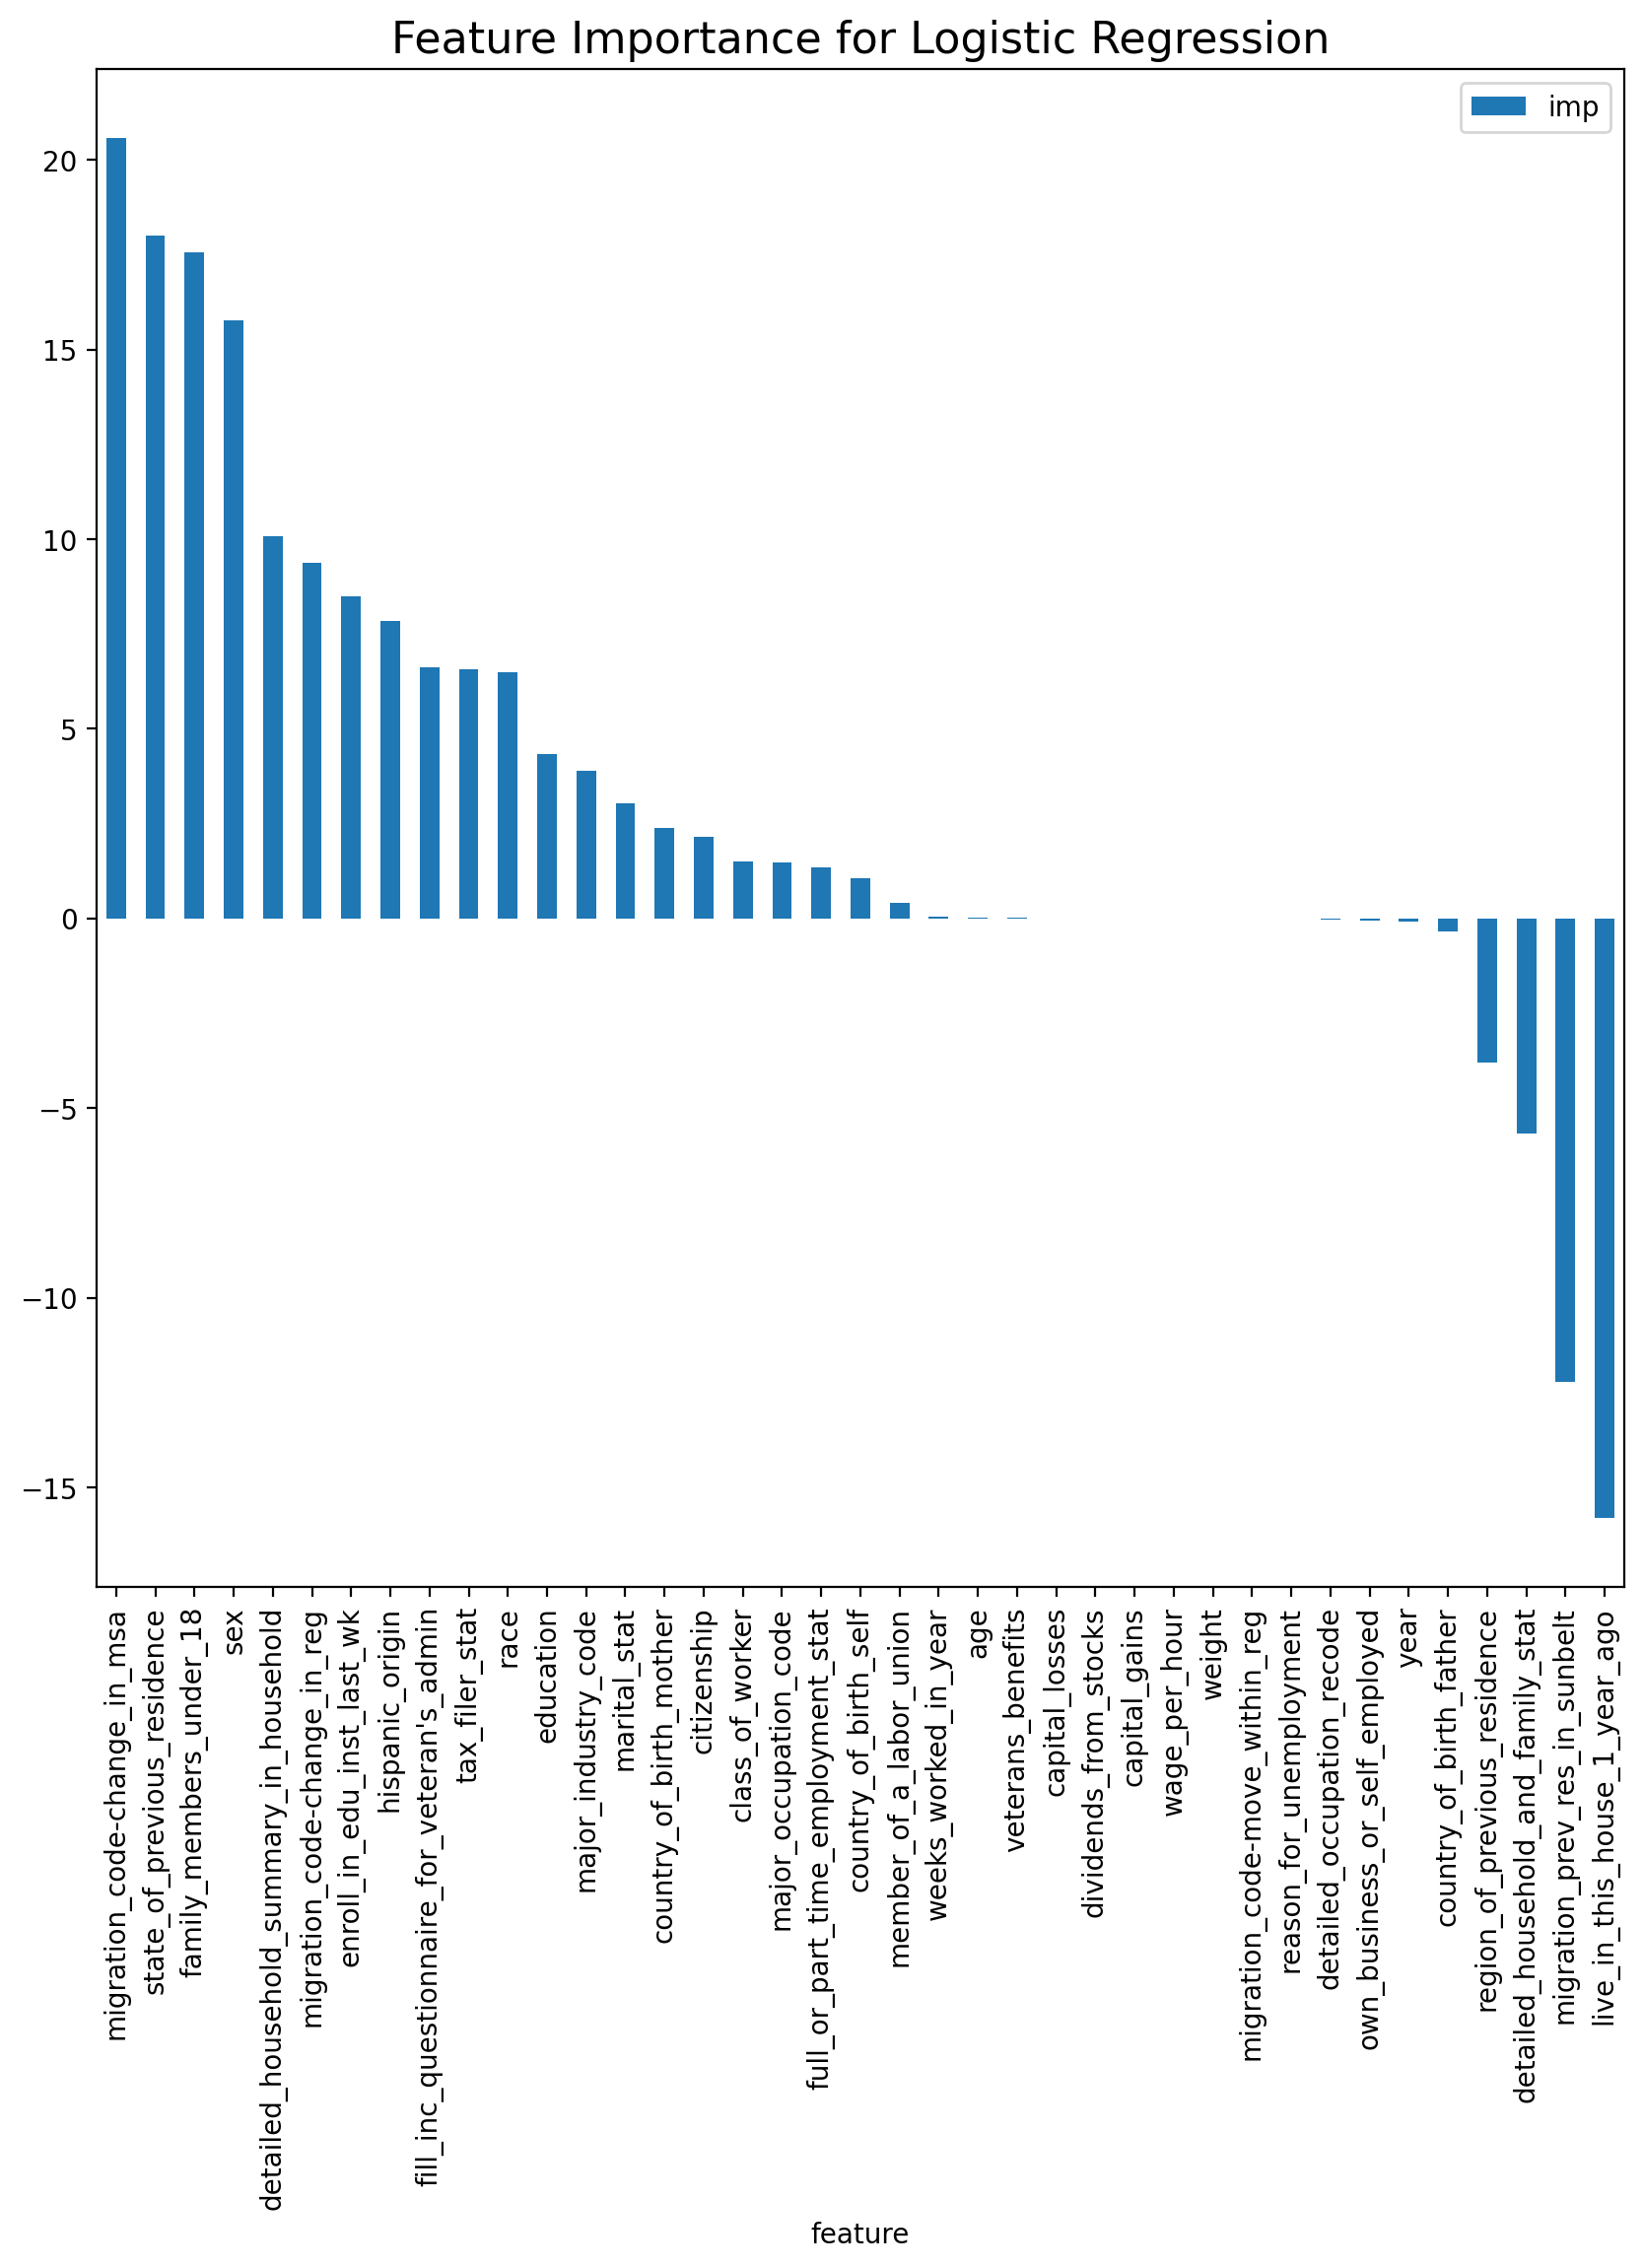

In [22]:
feature_imp_lr.plot(kind='bar',x='feature',y='imp',figsize=(10,10))
plt.title('Feature Importance for Logistic Regression',size = 16)

## 5.2 Random Forest Model - Normal Data

In [ ]:
# # Hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid = GridSearchCV(RandomForestClassifier(),param_grid,cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True),scoring='neg_log_loss')
# grid.fit(x_train2,y_train.values.ravel())
# print("Best parameters:", grid.best_params_)
# print("Best score:", grid.best_score_)

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best score: -0.12078367403449067


Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

Best score: -0.12078367403449067

In [23]:
rf = RandomForestClassifier(n_estimators = 300, max_depth = 20,
                            min_samples_split = 2, min_samples_leaf = 2)
rf.fit(x_train2,y_train.values.ravel())
y_val_preds_rf = rf.predict_proba(x_val2)[:,1]
loss = log_loss(y_val,y_val_preds_rf)
print("Log Loss for Optimal Random Forest Model:", loss)

feature_imp_rf = pd.DataFrame({'feature':x_train2.columns,'imp':rf.feature_importances_})
feature_imp_rf.sort_values(by='imp',ascending=False,inplace=True)


Log Loss for Optimal Random Forest Model: 0.1179729781539281


Text(0.5, 1.0, 'Feature Importance for Random Forest')

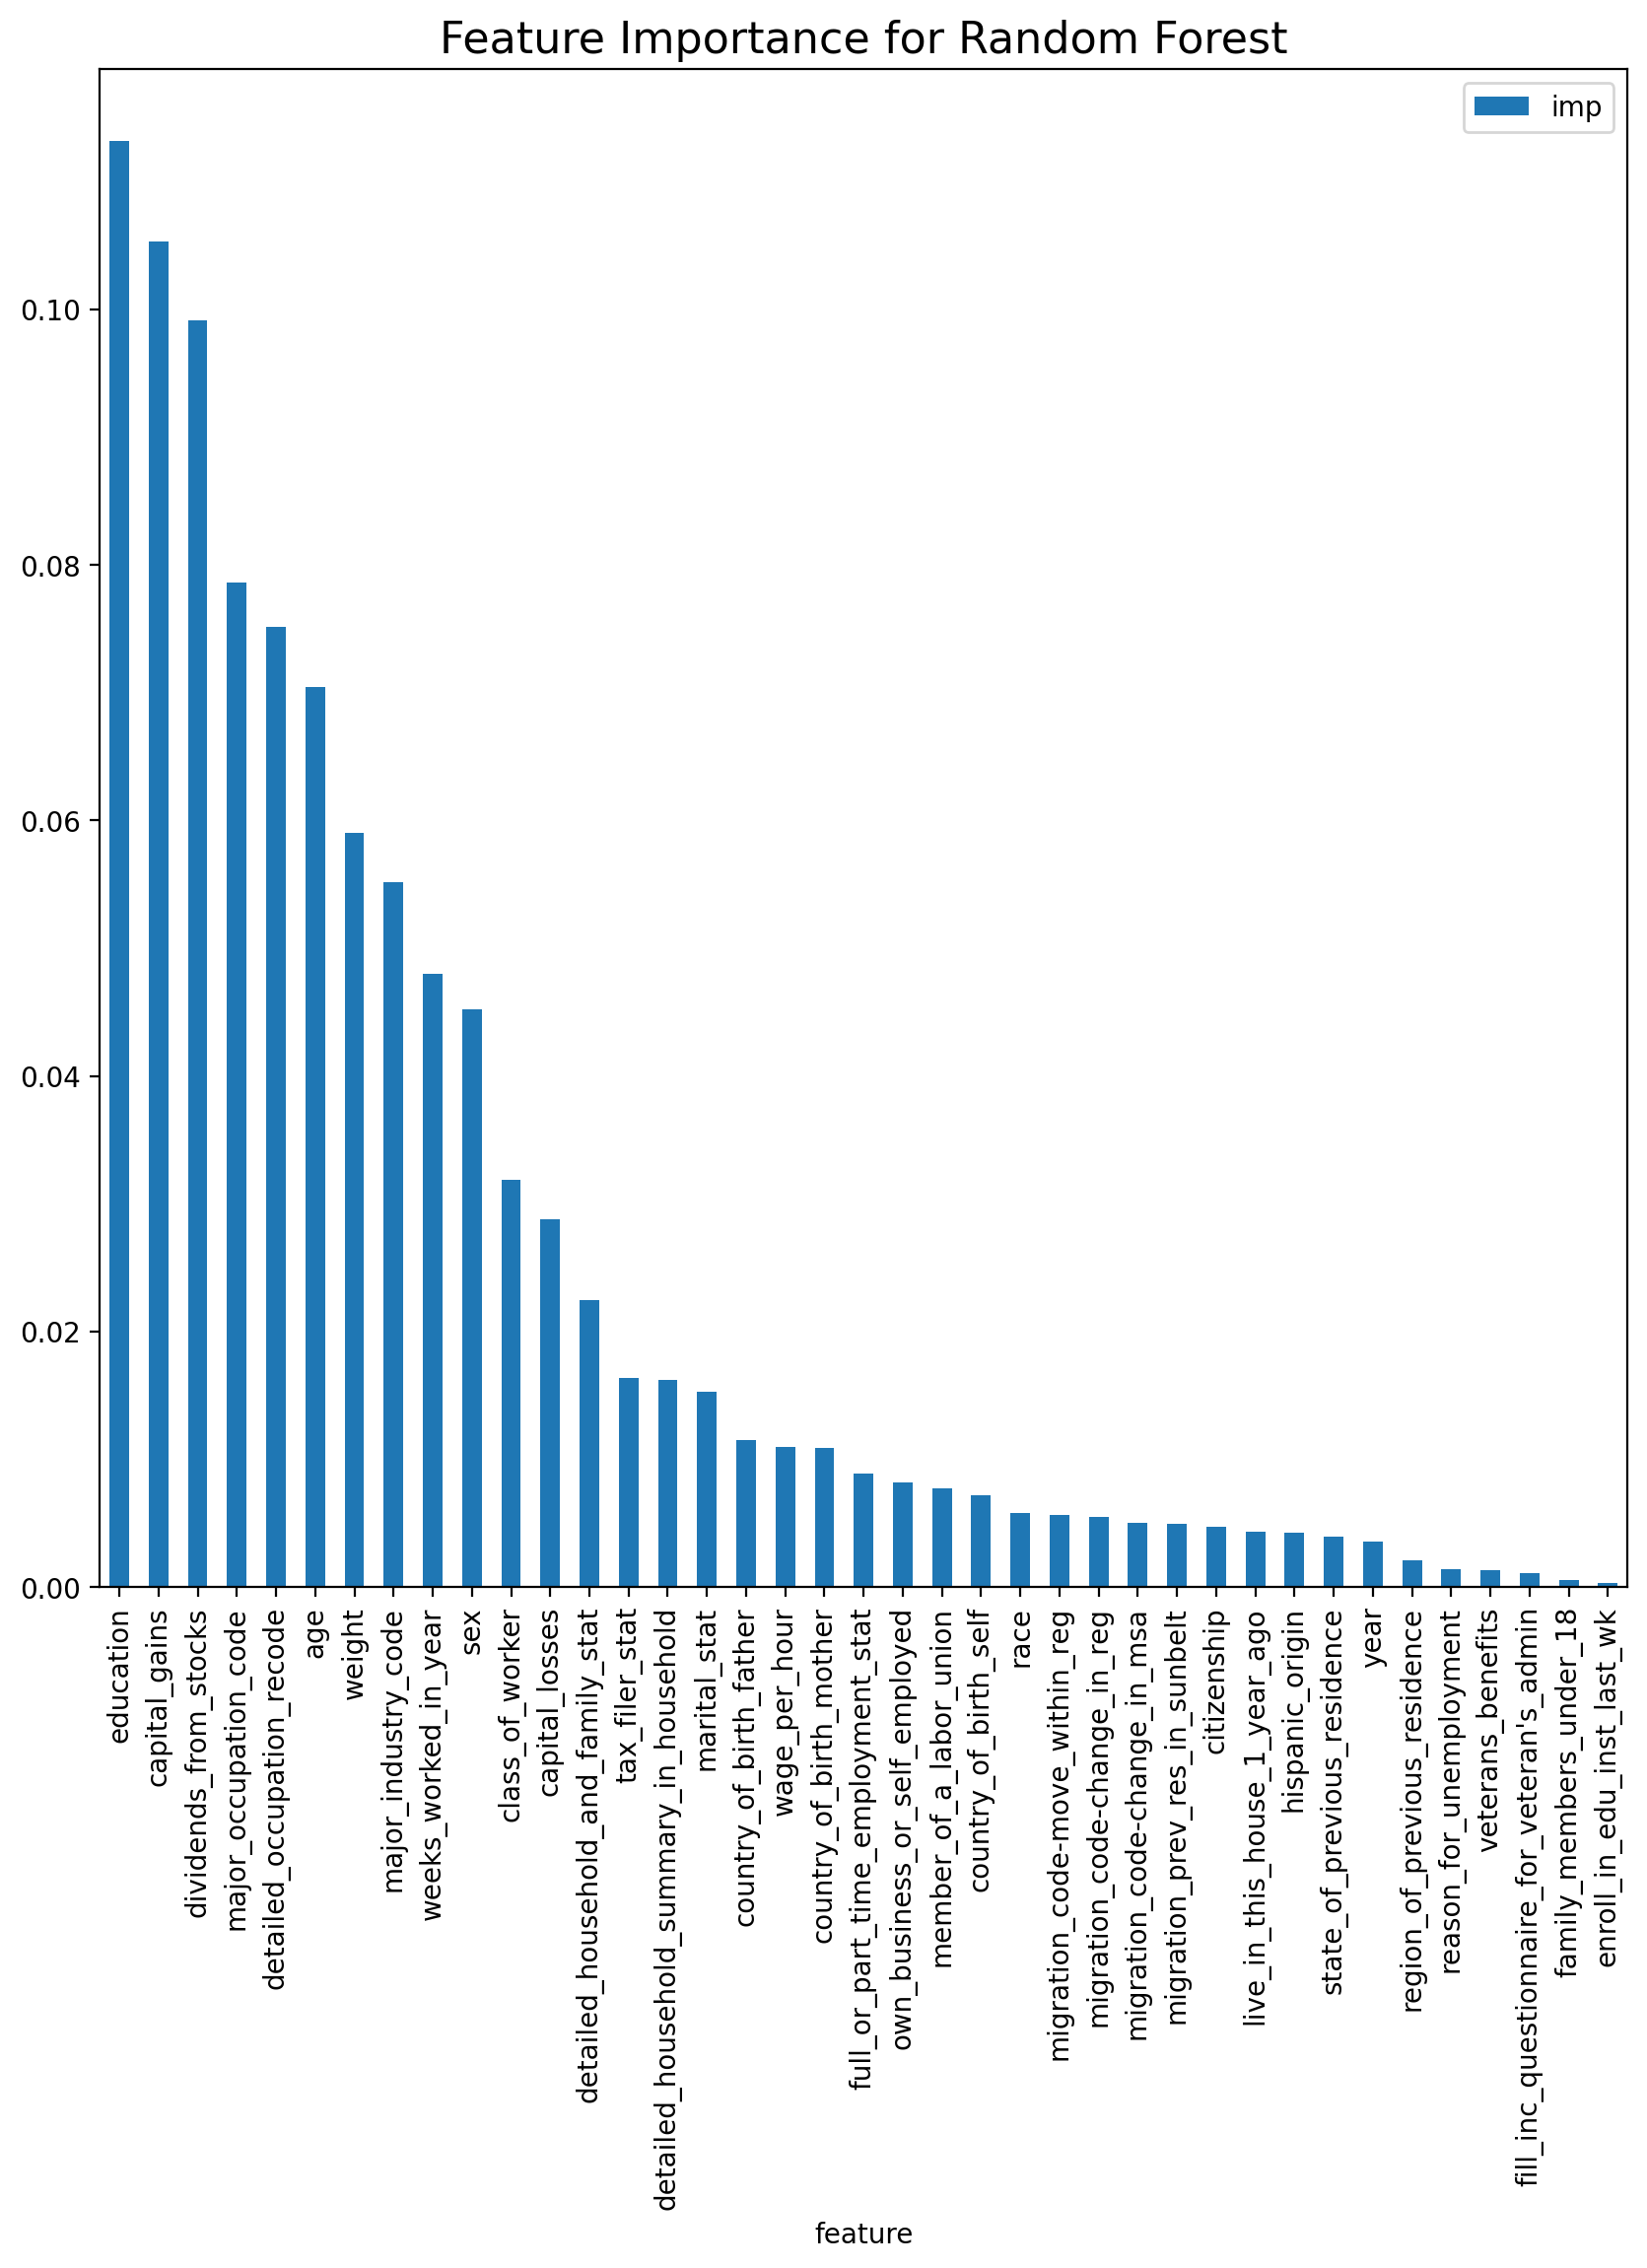

In [24]:
feature_imp_rf.plot(kind='bar',x='feature',y='imp',figsize=(10,10))
plt.title('Feature Importance for Random Forest',size = 16)

## 5.3 CatBoost Model - Normal Data

In [ ]:
# # Hyperparameter tuning
# param_grid = {
#     'learning_rate': [0.03, 0.05, 0.07],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [3, 5, 7],
#     'iterations': [100, 200, 300],
# }

# grid = GridSearchCV(CatBoostClassifier(allow_writing_files=False, cat_features=cat_cols,verbose=100),param_grid,cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True),scoring='neg_log_loss')
# grid.fit(x_train,y_train.values.ravel())
# print("Best parameters:", grid.best_params_)
# print("Best score:", grid.best_score_)

0:	learn: 0.6377786	total: 52.6ms	remaining: 5.21s
99:	learn: 0.1299779	total: 3.45s	remaining: 0us
0:	learn: 0.6372383	total: 38.1ms	remaining: 3.77s
99:	learn: 0.1297428	total: 3.1s	remaining: 0us
0:	learn: 0.6374195	total: 39.7ms	remaining: 3.93s
99:	learn: 0.1300704	total: 3.29s	remaining: 0us
0:	learn: 0.6412624	total: 35.7ms	remaining: 3.54s
99:	learn: 0.1290107	total: 3.15s	remaining: 0us
0:	learn: 0.6413579	total: 40.8ms	remaining: 4.04s
99:	learn: 0.1302748	total: 3.22s	remaining: 0us
0:	learn: 0.6032713	total: 37.7ms	remaining: 3.73s
99:	learn: 0.1253954	total: 3.19s	remaining: 0us
0:	learn: 0.6024280	total: 43.9ms	remaining: 4.34s
99:	learn: 0.1247108	total: 3.23s	remaining: 0us
0:	learn: 0.6027164	total: 38.1ms	remaining: 3.77s
99:	learn: 0.1247975	total: 3.18s	remaining: 0us
0:	learn: 0.6087627	total: 39.3ms	remaining: 3.89s
99:	learn: 0.1243566	total: 3.21s	remaining: 0us
0:	learn: 0.6089078	total: 35.6ms	remaining: 3.53s
99:	learn: 0.1255419	total: 3.11s	remaining: 0us
0

Best parameters: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.07}

Best score: -0.11636920350299151

In [25]:
cat = CatBoostClassifier(allow_writing_files=False,verbose=100,learning_rate=0.07,depth=8,iterations=300,l2_leaf_reg=3)
cat.fit(x_train,y_train,cat_features=cat_cols)
y_val_preds = cat.predict_proba(x_val)[:,1]
loss = log_loss(y_val,y_val_preds)
print("Log Loss for Optimal CatBoost Model:", loss)

feature_imp_cat = pd.DataFrame({'feature':x_train.columns,'imp':cat.feature_importances_})
feature_imp_cat.sort_values(by='imp',ascending=False,inplace=True)

0:	learn: 0.5689602	total: 386ms	remaining: 1m 55s
100:	learn: 0.1139548	total: 42.5s	remaining: 1m 23s
200:	learn: 0.1079467	total: 1m 4s	remaining: 31.9s
299:	learn: 0.1035147	total: 1m 30s	remaining: 0us
Log Loss for Optimal CatBoost Model: 0.1132921664965228


Text(0.5, 1.0, 'Feature Importance for CatBoost')

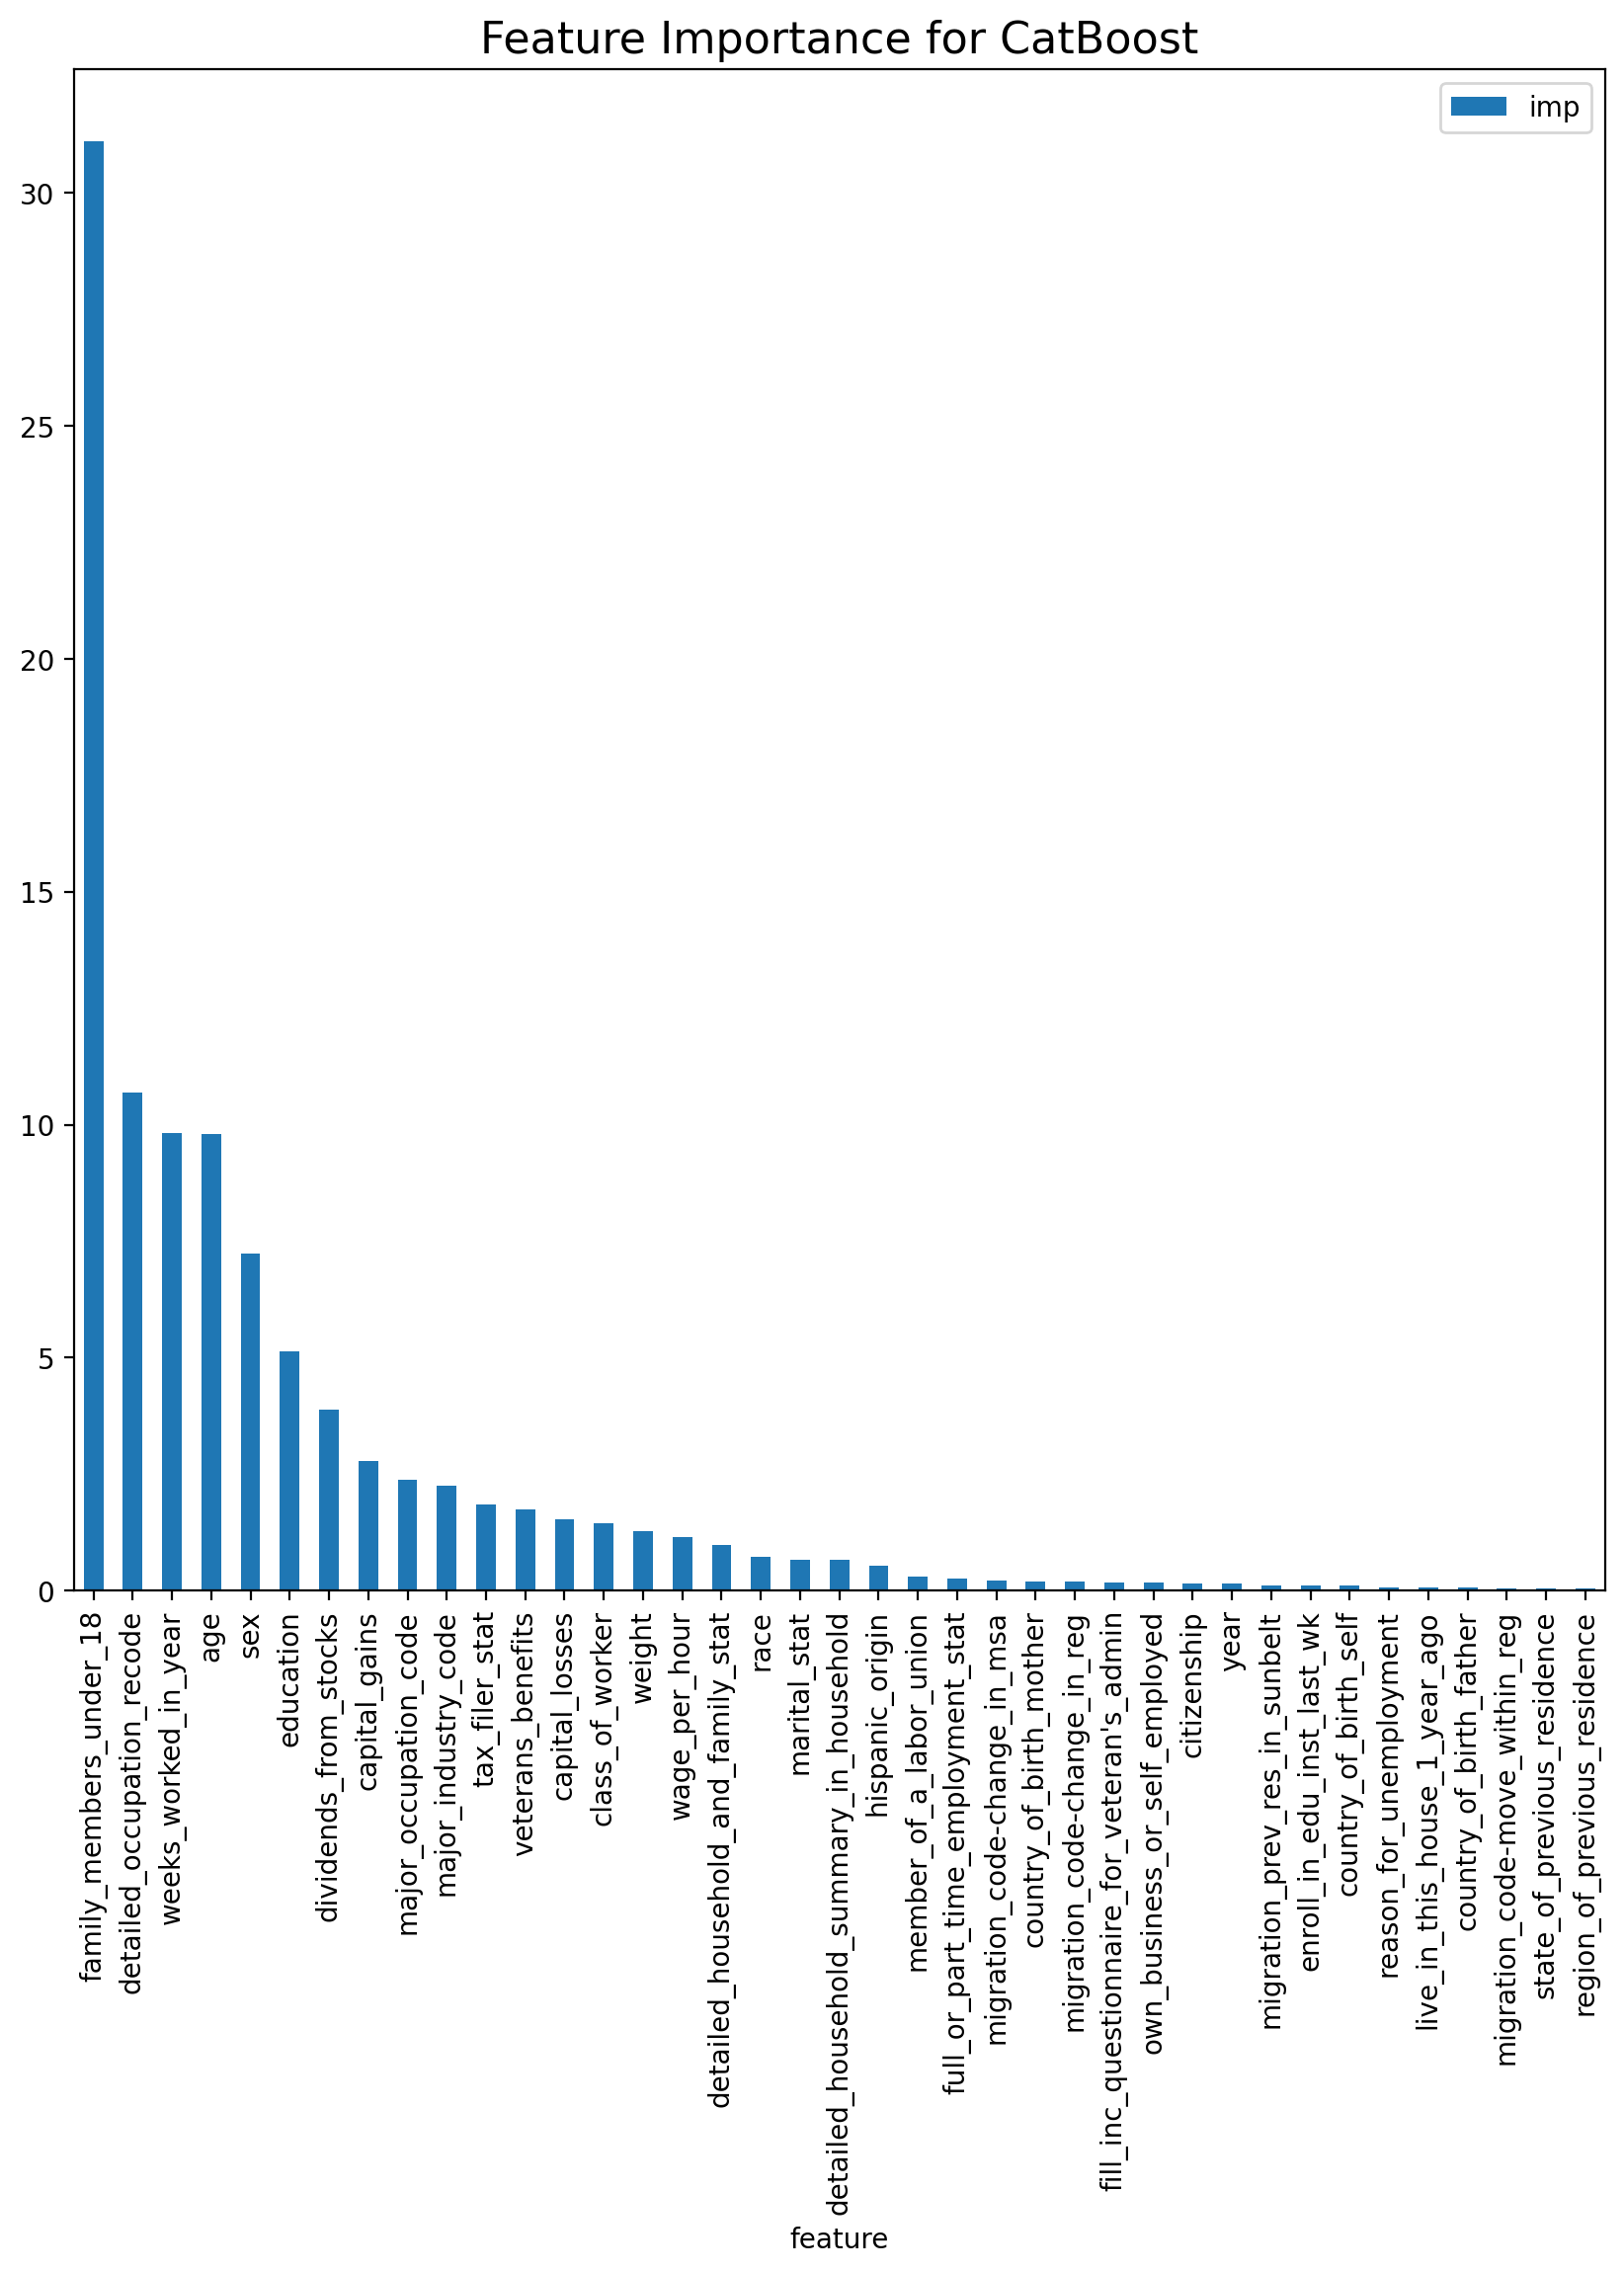

In [26]:
feature_imp_cat.plot(kind='bar',x='feature',y='imp',figsize=(10,10))
plt.title('Feature Importance for CatBoost',size = 16)

## 5.4 Logistic Regression Model - SMOTE Data

In [ ]:
# # Hyperparameter tuning

# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10],
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }

# grid = GridSearchCV(LogisticRegression(),param_grid,cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True),scoring='neg_log_loss')
# grid.fit(x_train_smote,y_train_smote.values.ravel())
# print("Best parameters:", grid.best_params_)
# print("Best score:", grid.best_score_)

Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: -0.28520517673428103


Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Best score: -0.28520517673428103

In [ ]:
lr_smote = LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear')
lr_smote.fit(x_train_smote,y_train_smote.values.ravel())
y_val_preds = lr.predict_proba(x_val2)[:,1]
loss = log_loss(y_val,y_val_preds)
print("Log Loss for Optimal Logistic Regression Model (SMOTE):", loss)

coeffs = lr_smote.coef_[0]
feature_imp_lr_smote = pd.DataFrame({'feature':x_train_smote.columns,'imp':coeffs})
feature_imp_lr_smote.sort_values(by='imp',ascending=False,inplace=True)

Log Loss for Optimal Logistic Regression Model: 0.12939529109123055


Text(0.5, 1.0, 'Feature Importance for Logistic Regression (SMOTE)')

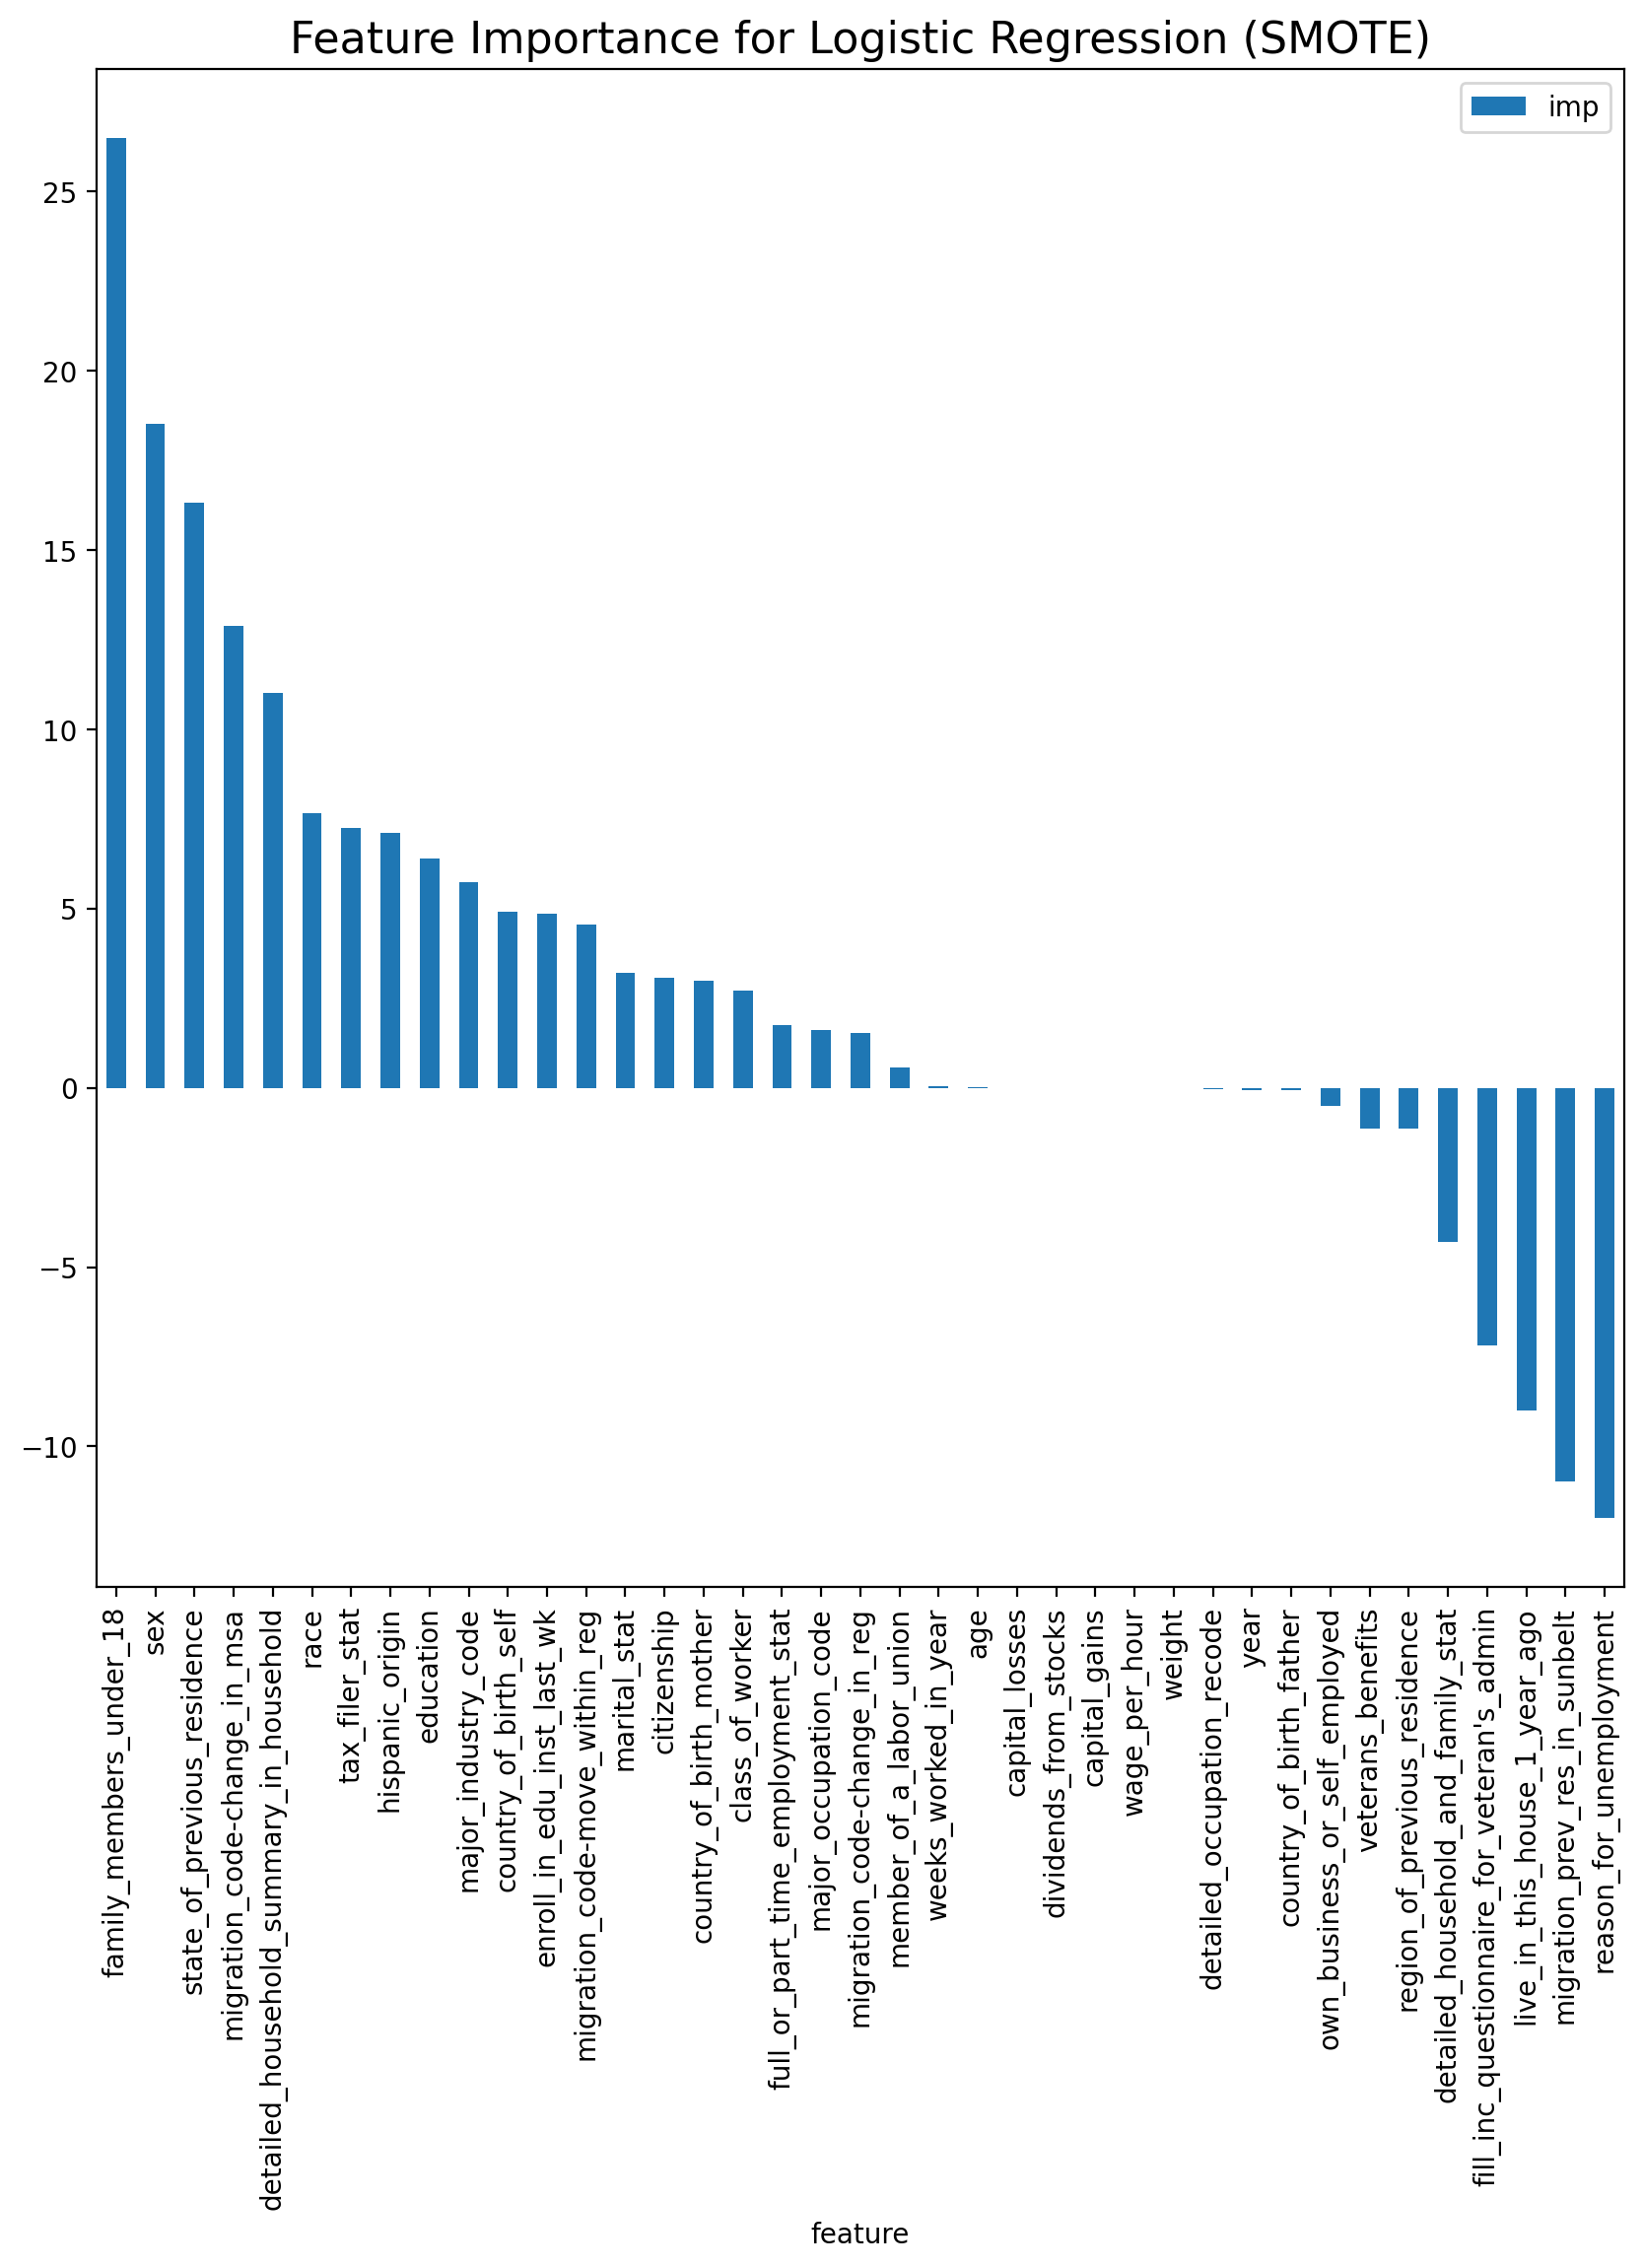

In [29]:
feature_imp_lr_smote.plot(kind='bar',x='feature',y='imp',figsize=(10,10))
plt.title('Feature Importance for Logistic Regression (SMOTE)',size = 16)

## 5.5. Random Forest Model - SMOTE Data

In [31]:
# # Hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid = GridSearchCV(RandomForestClassifier(),param_grid,cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True),scoring='neg_log_loss')
# grid.fit(x_train_smote,y_train_smote.values.ravel())
# print("Best parameters:", grid.best_params_)
# print("Best score:", grid.best_score_)

The above step was skipped due to time required for the code to run. This would have helped us in fine tuning and finding the optimal paramters when we are using synthetic data generated using SMOTE

In [32]:
rf_smote = RandomForestClassifier(n_estimators = 300, max_depth = 20,
                            min_samples_split = 2, min_samples_leaf = 2)
rf_smote.fit(x_train_smote,y_train_smote.values.ravel())
y_val_preds_rf = rf.predict_proba(x_val2)[:,1]
loss = log_loss(y_val,y_val_preds_rf)
print("Log Loss for Optimal Random Forest Model (SMOTE):", loss)

feature_imp_rf_smote = pd.DataFrame({'feature':x_train_smote.columns,'imp':rf_smote.feature_importances_})
feature_imp_rf_smote.sort_values(by='imp',ascending=False,inplace=True)


Log Loss for Optimal Random Forest Model (SMOTE): 0.1179729781539281


Text(0.5, 1.0, 'Feature Importance for Random Forest (SMOTE)')

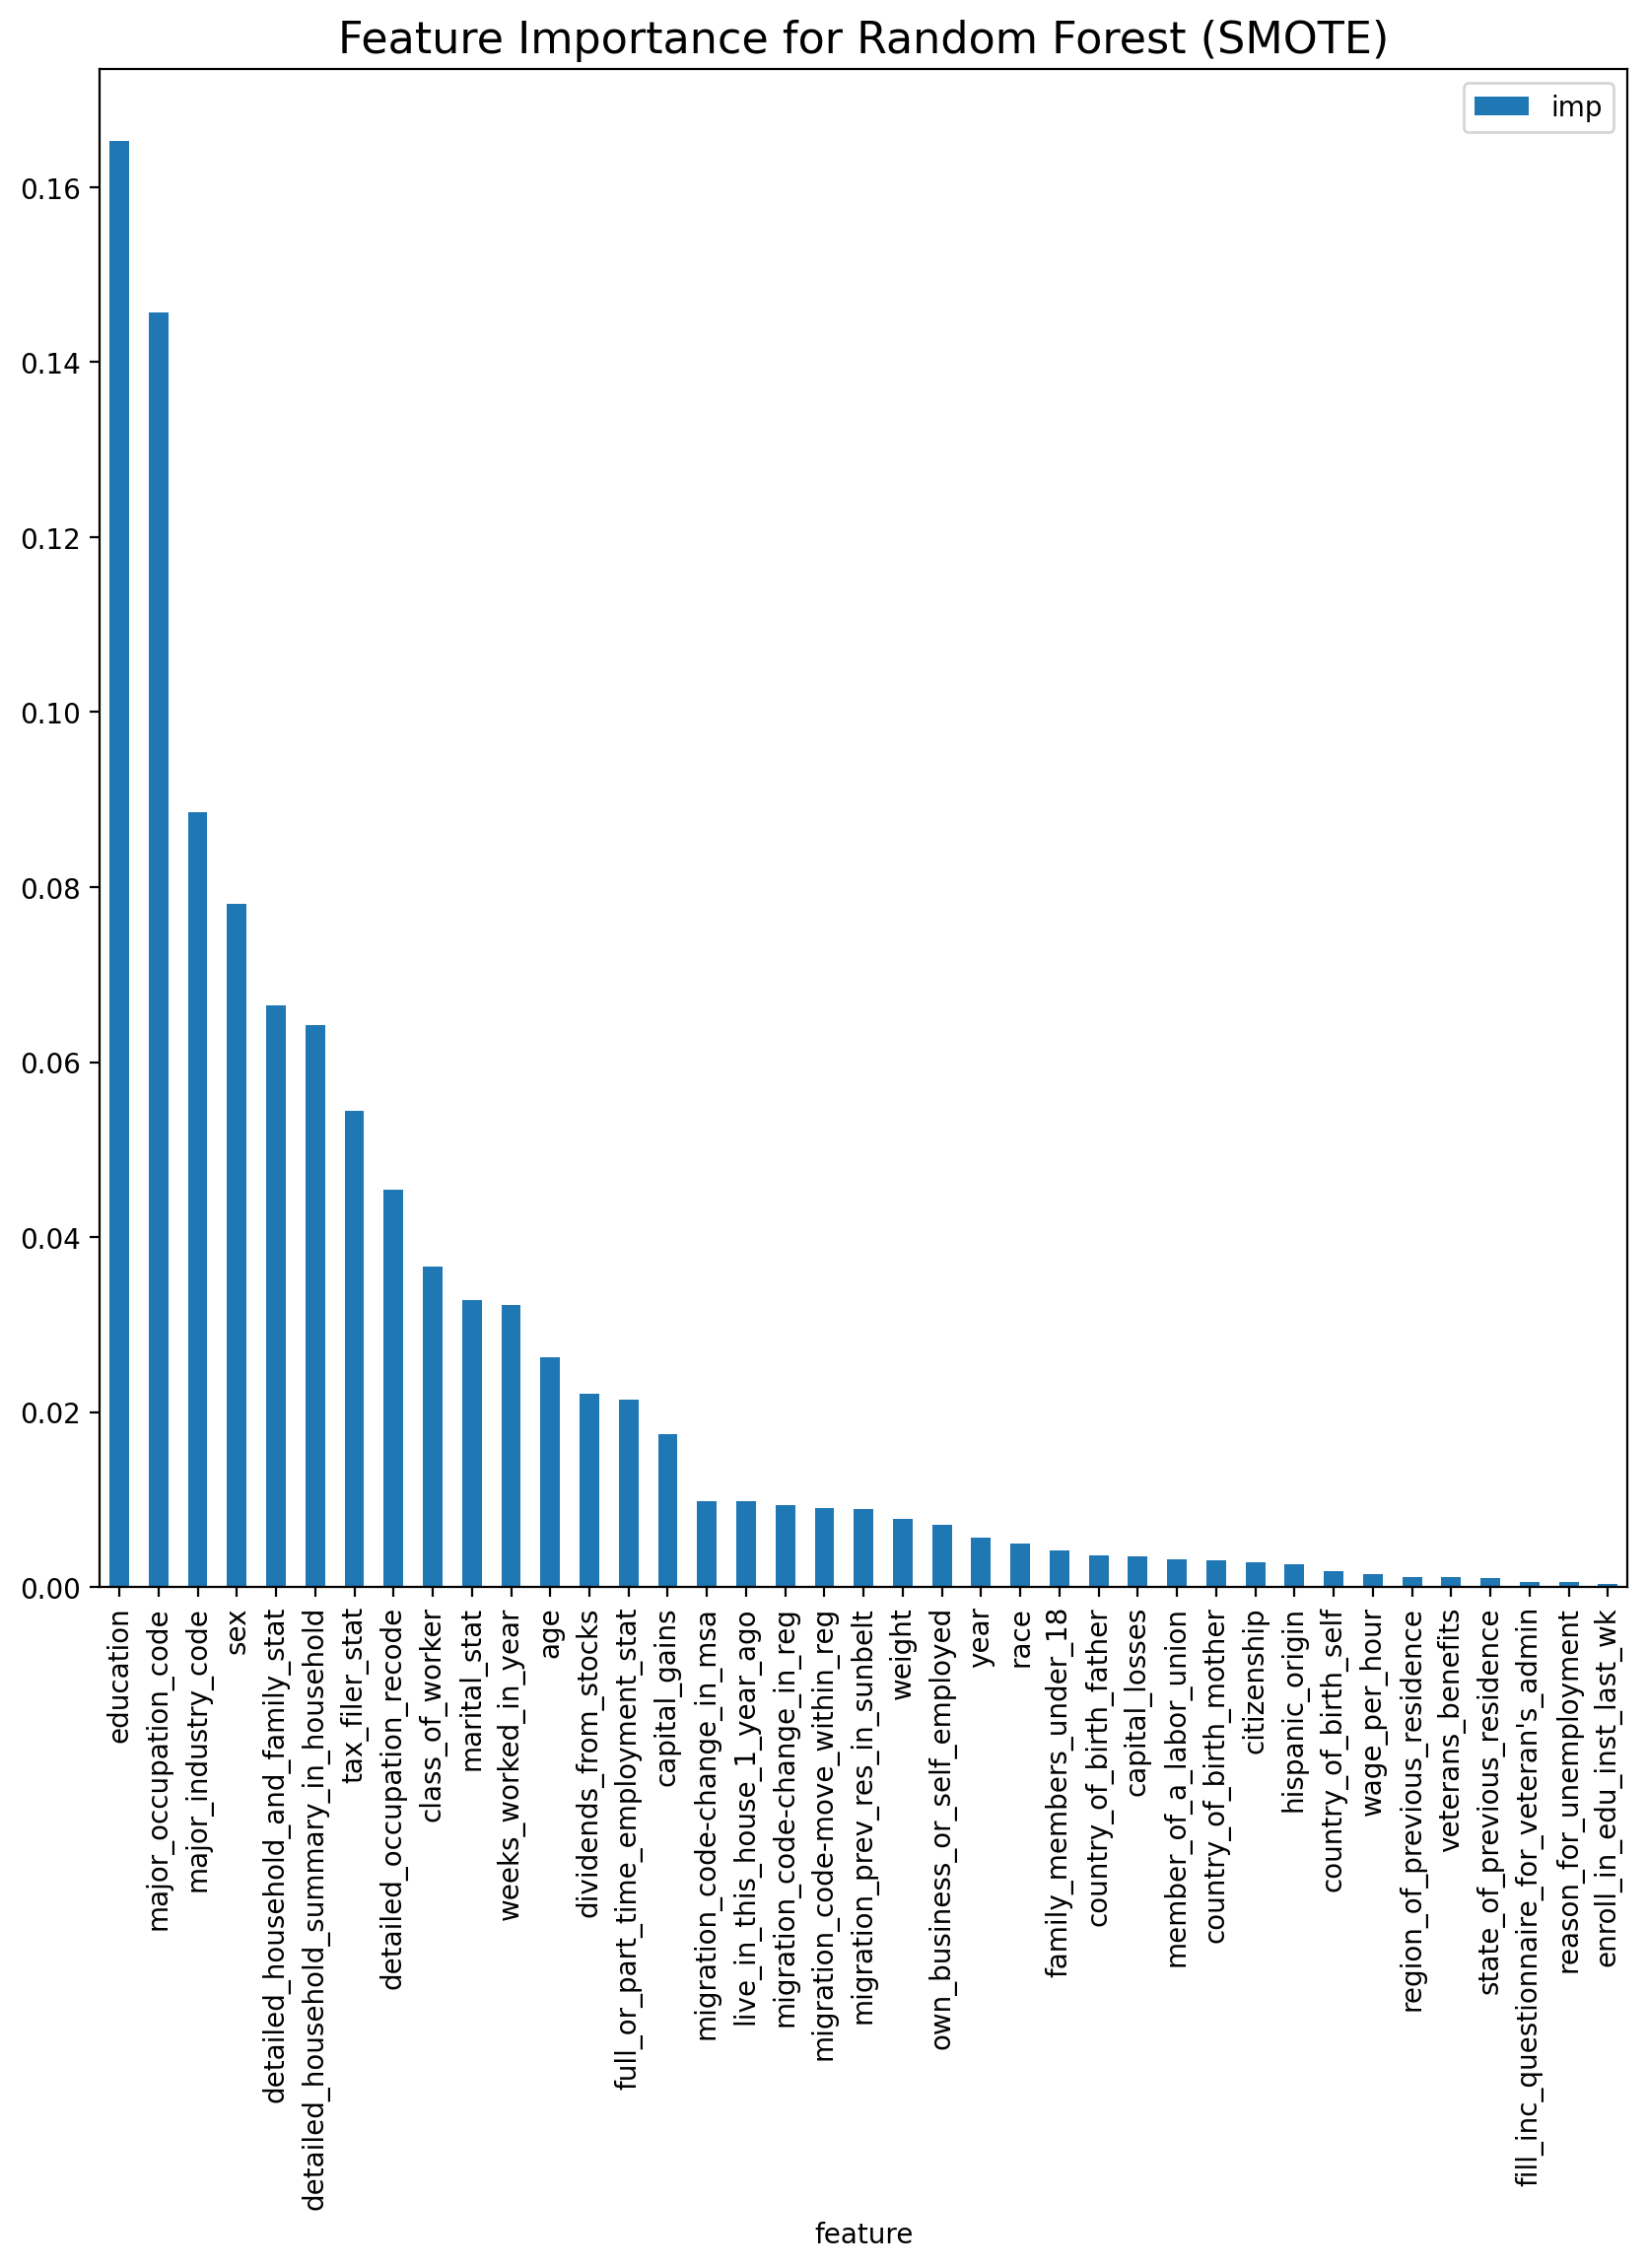

In [33]:
feature_imp_rf_smote.plot(kind='bar',x='feature',y='imp',figsize=(10,10))
plt.title('Feature Importance for Random Forest (SMOTE)',size = 16)

## 5.6. CatBoost Model - SMOTE Data

In [ ]:
# # Hyperparameter tuning
# param_grid = {
#     'learning_rate': [0.03, 0.05, 0.07],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [3, 5, 7],
#     'iterations': [100, 200, 300],
# }

# grid = GridSearchCV(CatBoostClassifier(allow_writing_files=False,verbose=100),param_grid,cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True),scoring='neg_log_loss')
# grid.fit(x_train_smote,y_train_smote.values.ravel())
# print("Best parameters:", grid.best_params_)
# print("Best score:", grid.best_score_)

The above step was skipped due to time required for the code to run. This would have helped us in fine tuning and finding the optimal paramters when we are using synthetic data generated using SMOTE

In [39]:
cat_smote = CatBoostClassifier(allow_writing_files=False,verbose=100,learning_rate=0.07,depth=8,iterations=300,l2_leaf_reg=3)
cat_smote.fit(x_train_smote,y_train_smote.values.ravel())
y_val_preds = cat_smote.predict_proba(x_val2)[:,1]
loss = log_loss(y_val,y_val_preds)
print("Log Loss for Optimal CatBoost Model (SMOTE):", loss)

feature_imp_cat_smote = pd.DataFrame({'feature':x_train_smote.columns,'imp':cat_smote.feature_importances_})
feature_imp_cat_smote.sort_values(by='imp',ascending=False,inplace=True)

0:	learn: 0.5487209	total: 71.5ms	remaining: 21.4s
100:	learn: 0.0781779	total: 5.47s	remaining: 10.8s
200:	learn: 0.0676487	total: 9.03s	remaining: 4.45s
299:	learn: 0.0621404	total: 12.4s	remaining: 0us
Log Loss for Optimal CatBoost Model (SMOTE): 0.11799767949709222


Text(0.5, 1.0, 'Feature Importance for CatBoost (SMOTE)')

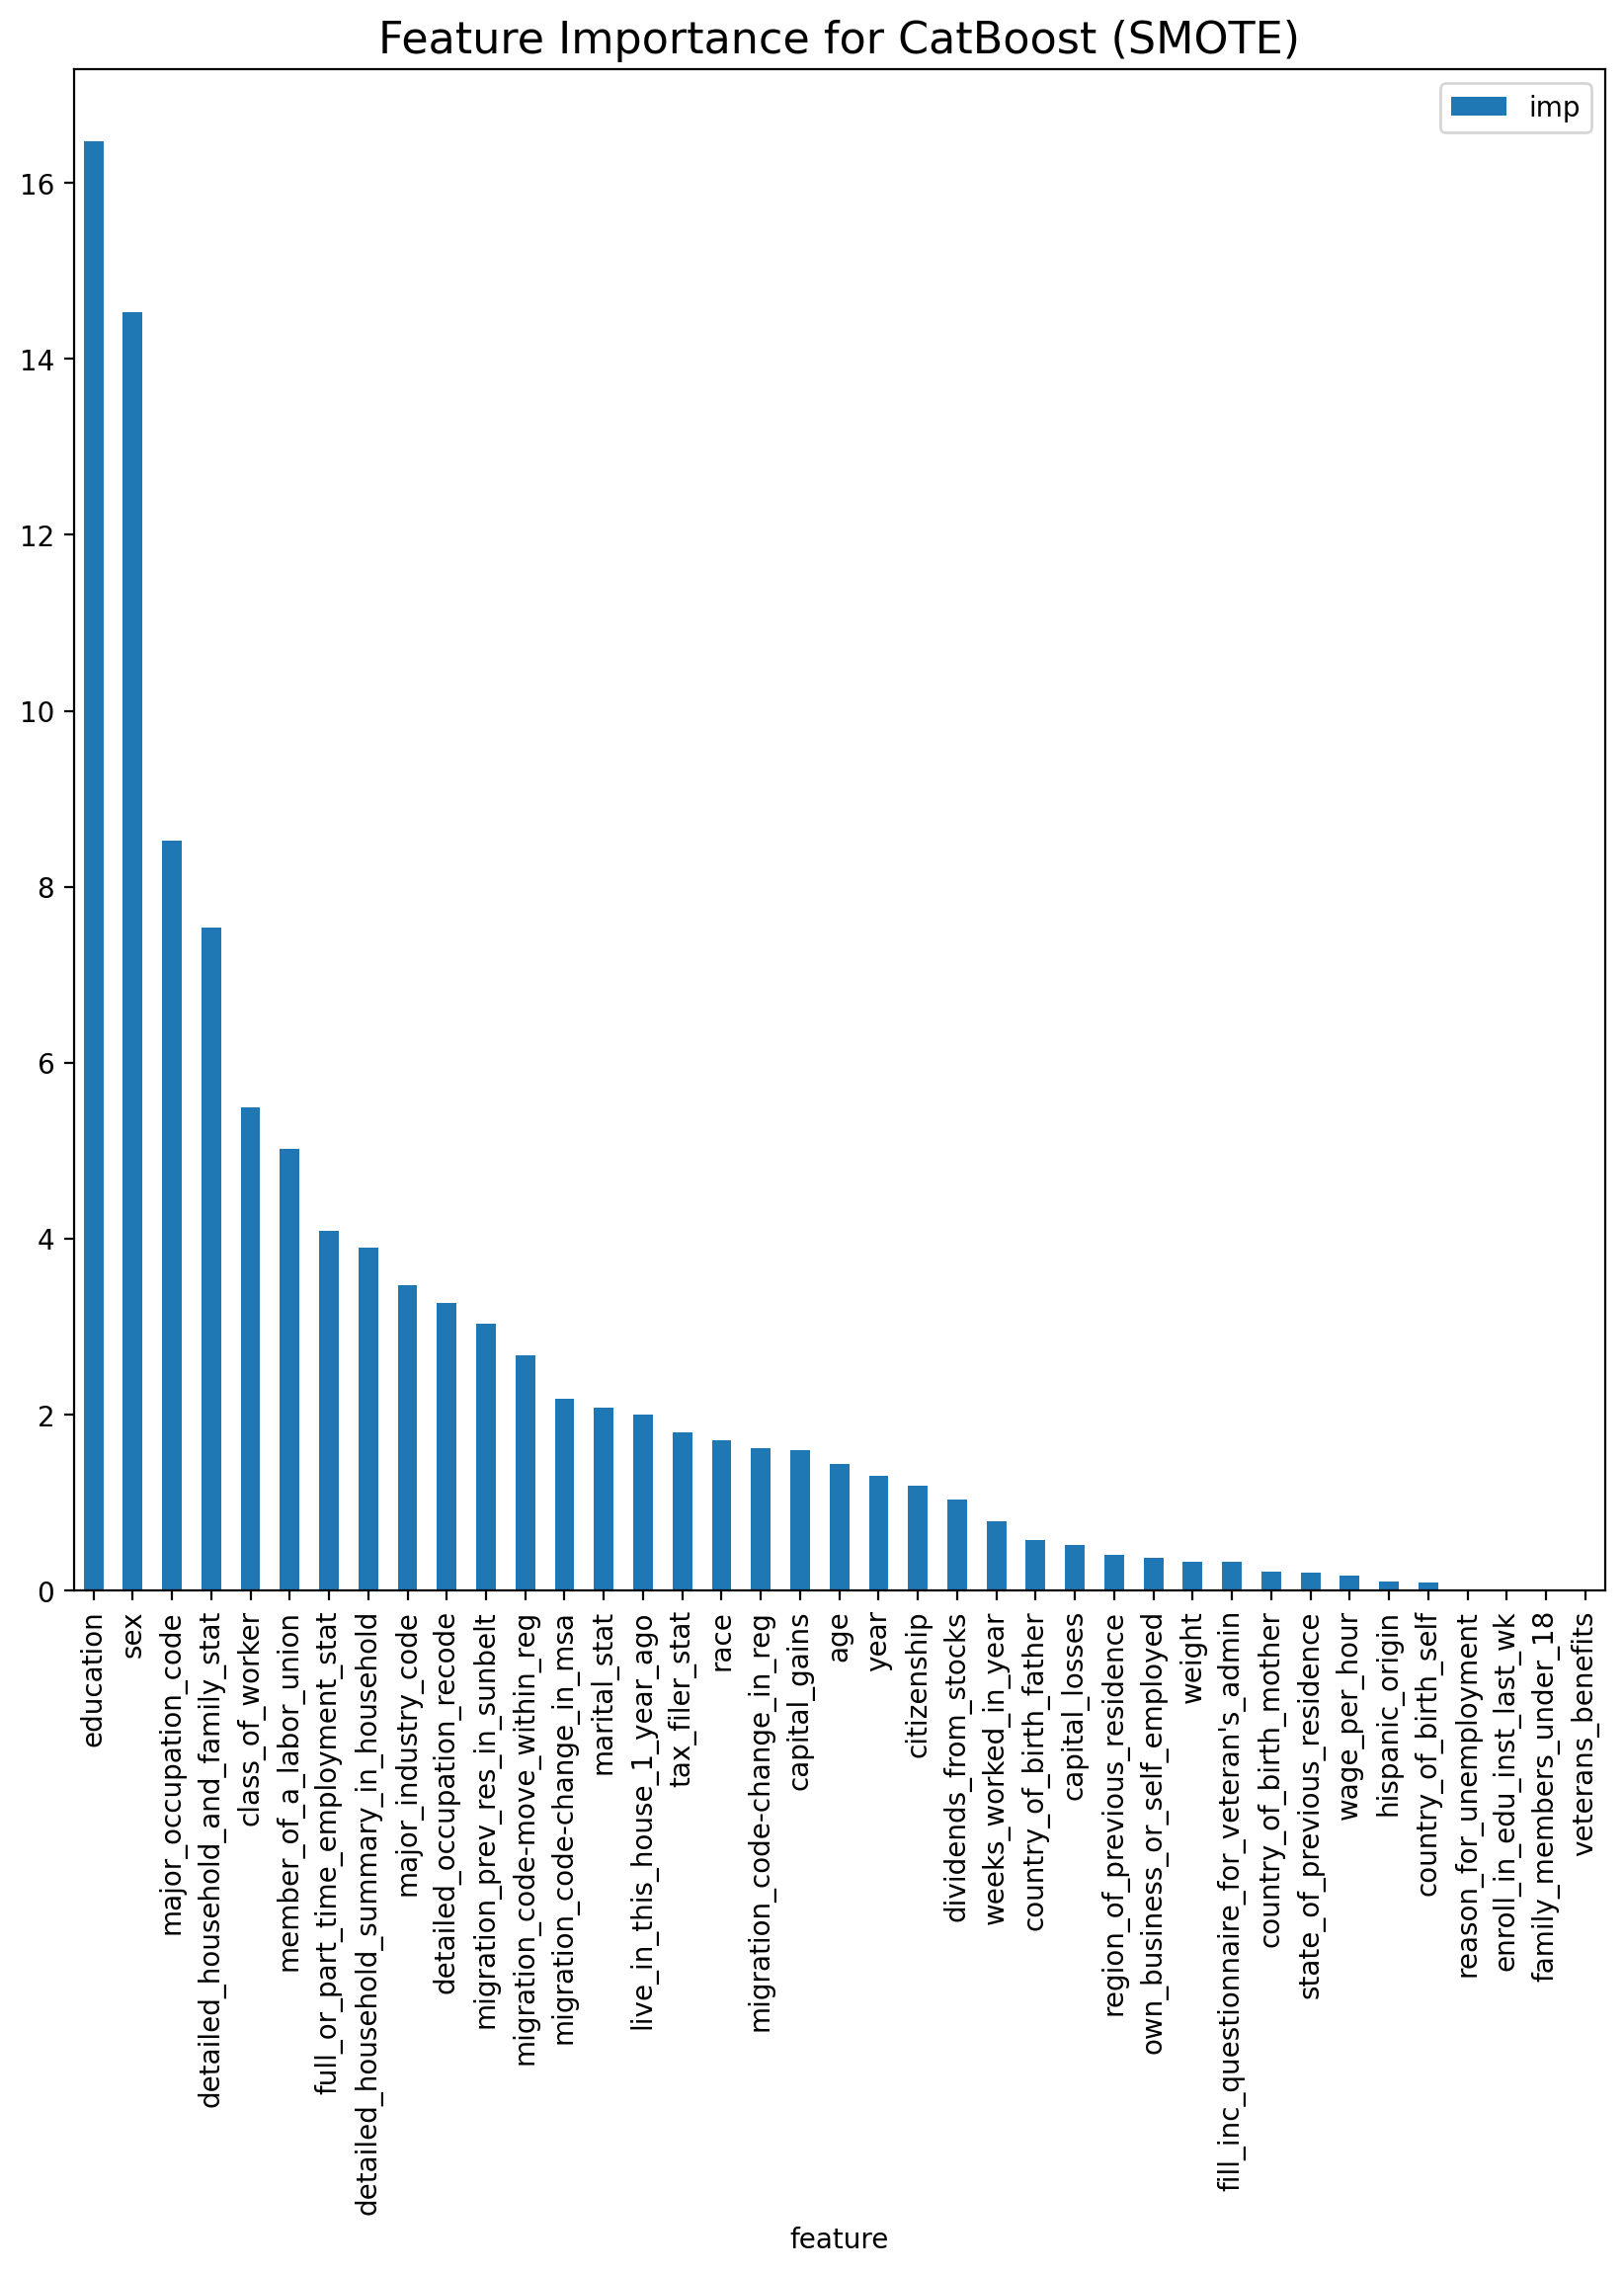

In [40]:
feature_imp_cat_smote.plot(kind='bar',x='feature',y='imp',figsize=(10,10))
plt.title('Feature Importance for CatBoost (SMOTE)',size = 16)

## 5.7 Ensemble Model Random Forest

In [79]:
# Creating an ensemble of 10 CatBoost models
k=10
skf = StratifiedKFold(n_splits=k,
                      shuffle=True,
                      random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in skf.split(np.zeros(len(y_dev)), # Placeholder (dummy input)
                                          y_dev): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)
loss_rf_ensemble_valid = []
models_rf_ensemble = []
encoder_rf_ensemble = []
f1_score_rf_ensemble = []
probabs_rf_ensemble_test = np.zeros([len(x_test),k])
for j in range(k):
    
    rf_ensemble_tmp = RandomForestClassifier(n_estimators = 300, max_depth = 20,
                            min_samples_split = 2, min_samples_leaf = 2)

    x_train_ensemble_tmp = x_dev.iloc[list_of_train_index[j], :]
    x_valid_ensemble_tmp = x_dev.iloc[list_of_valid_index[j], :]

    y_true_train_ensemble_tmp = y_dev.iloc[list_of_train_index[j]]
    y_true_valid_ensemble_tmp = y_dev.iloc[list_of_valid_index[j]]

    encoder = TargetEncoder()
    encoder.fit(x_train_ensemble_tmp[cat_cols],y_true_train_ensemble_tmp)

    x_test_ensemble_tmp = x_test.copy()
    x_train_ensemble_tmp[cat_cols] = encoder.transform(x_train_ensemble_tmp[cat_cols])
    x_valid_ensemble_tmp[cat_cols] = encoder.transform(x_valid_ensemble_tmp[cat_cols])
    x_test_ensemble_tmp[cat_cols] = encoder.transform(x_test[cat_cols])
    
    

    rf_ensemble_tmp.fit(x_train_ensemble_tmp,y_true_train_ensemble_tmp)
    probabs_ensemble_tmp = rf_ensemble_tmp.predict_proba(x_valid_ensemble_tmp)[:,1]
    loss_rf_ensemble_valid.append(log_loss(y_true_valid_ensemble_tmp,probabs_ensemble_tmp))
    f1_score_rf_ensemble.append(f1_score(y_true_valid_ensemble_tmp,np.where(probabs_ensemble_tmp > 0.5, 1, 0)))
    
    probabs_ensemble_tmp = rf_ensemble_tmp.predict_proba(x_valid_ensemble_tmp)[:,1]
    probabs_rf_ensemble_test[:,j] = rf_ensemble_tmp.predict_proba(x_test_ensemble_tmp)[:,1]
    
    models_rf_ensemble.append(rf_ensemble_tmp)
    encoder_rf_ensemble.append(encoder)

     

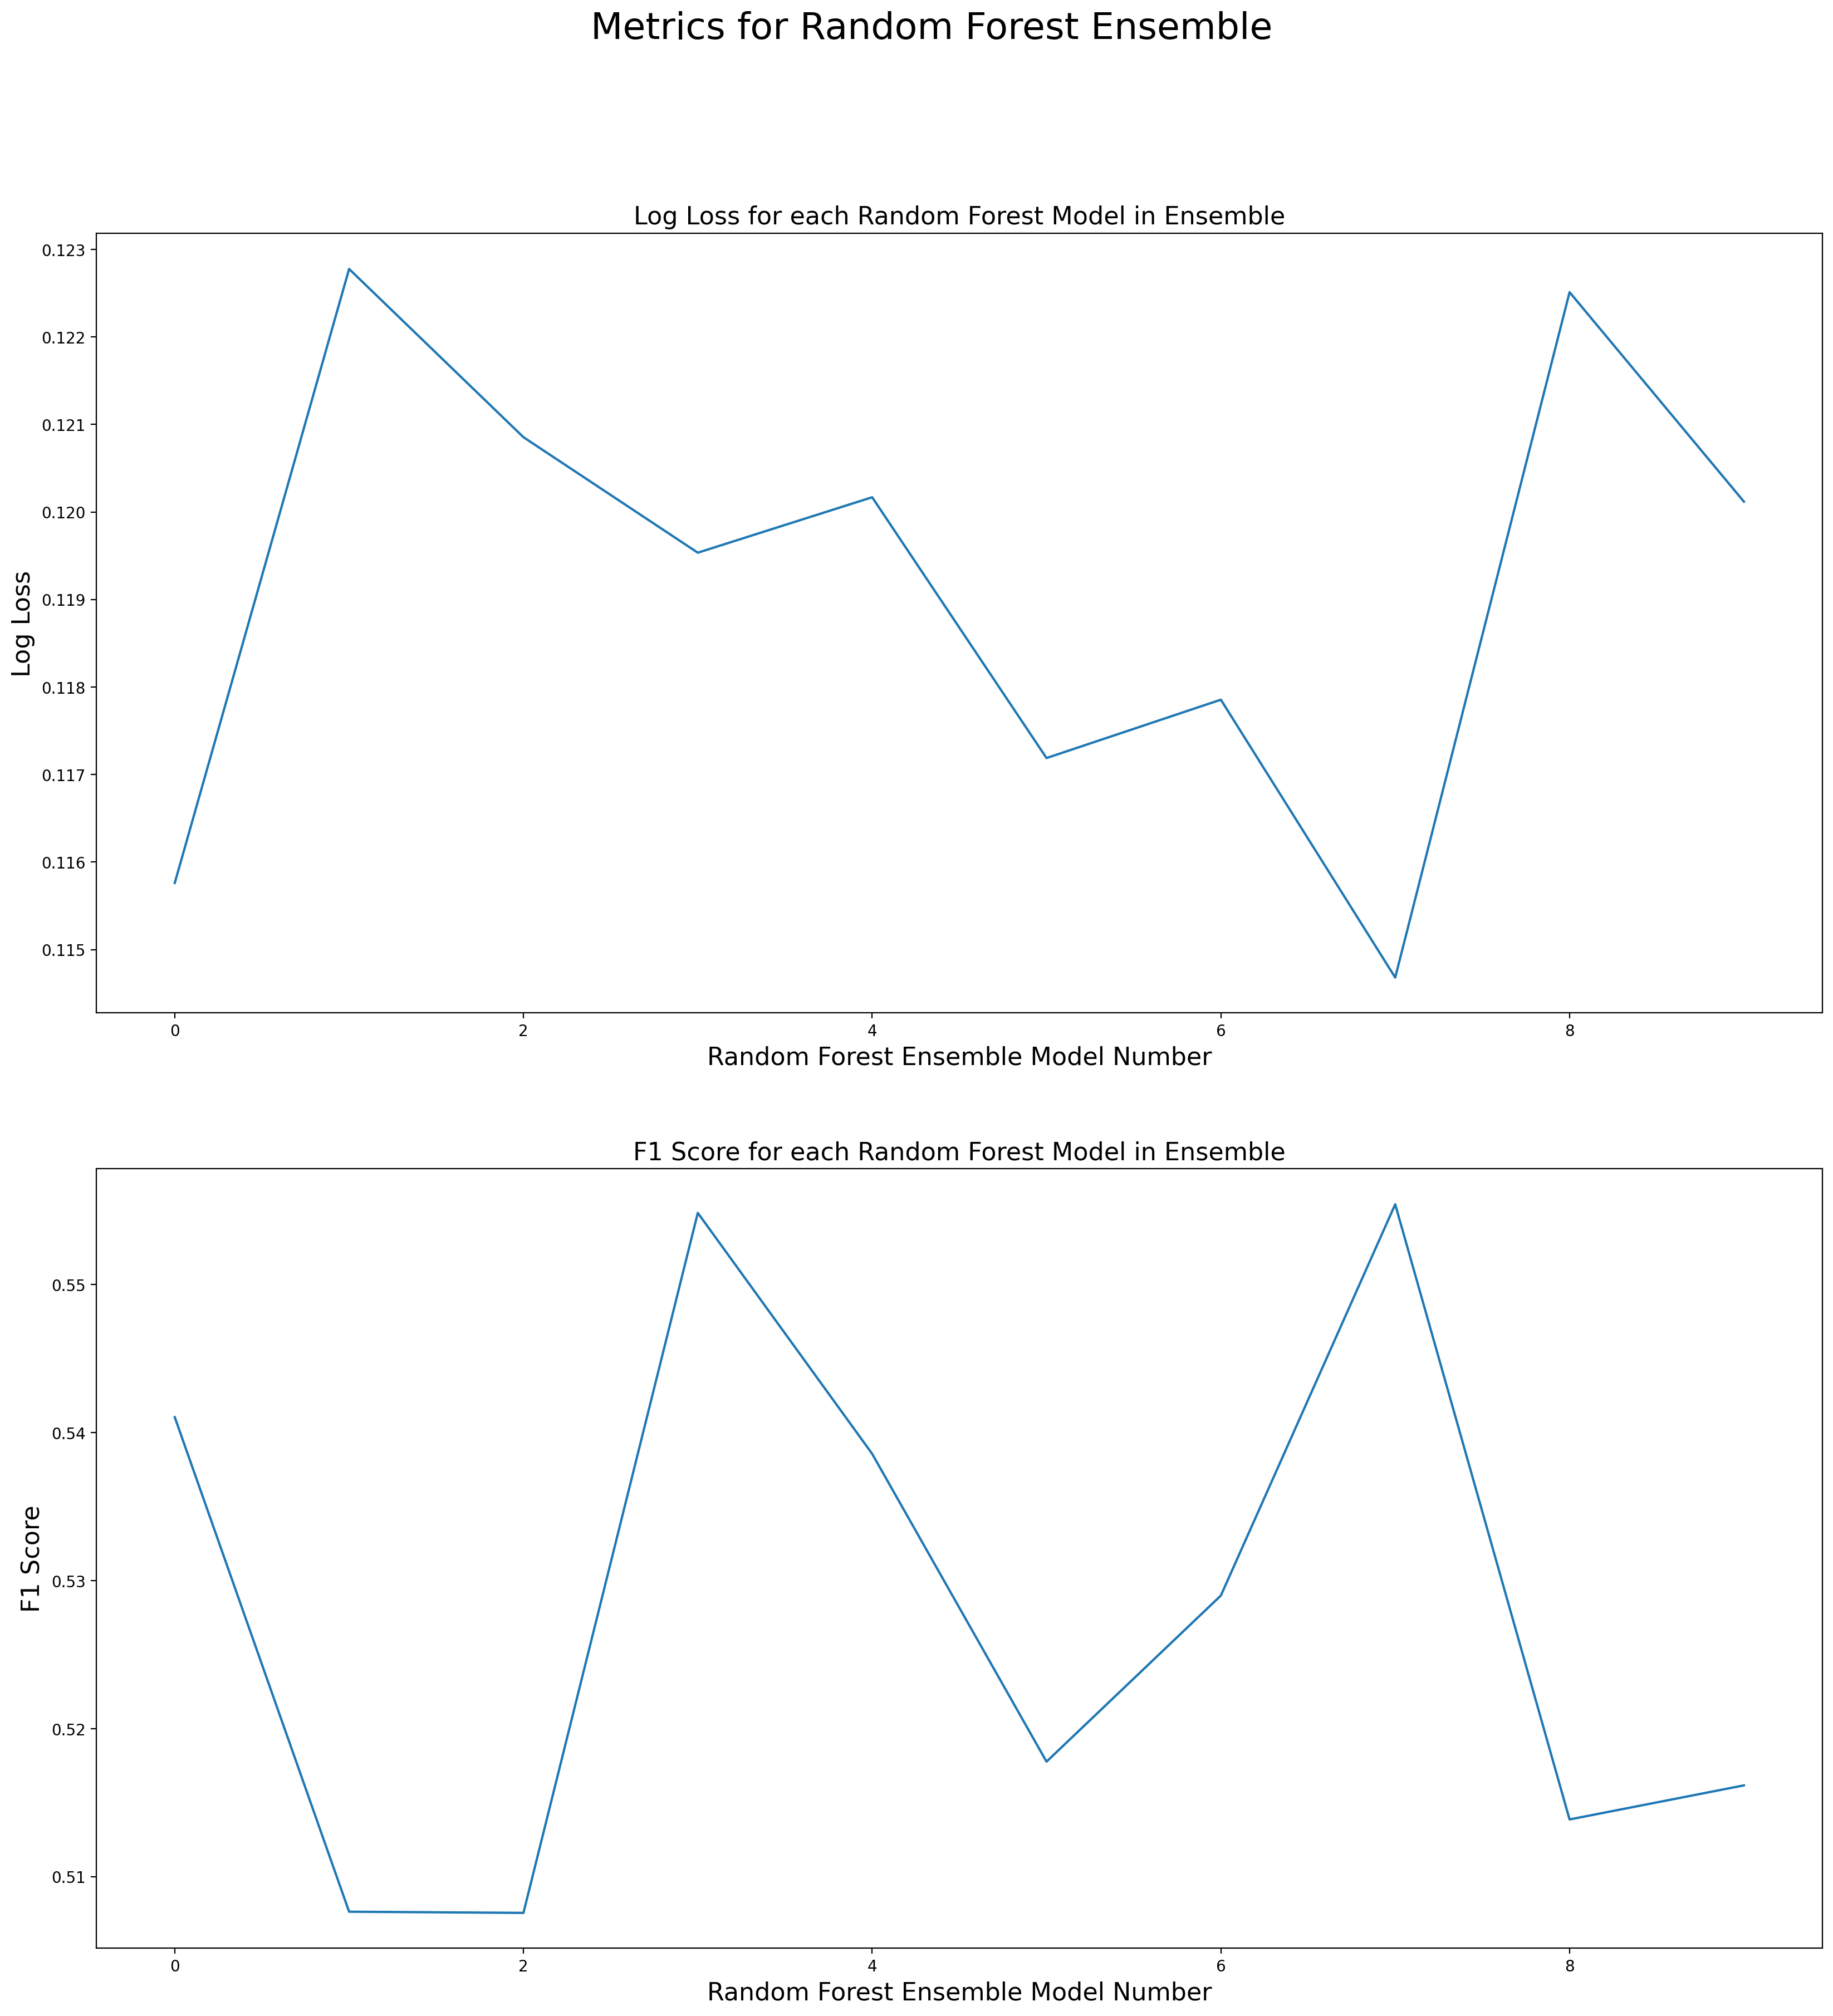

In [83]:

fig, axs = plt.subplots(2,1,figsize=(20,20))
fig.suptitle('Metrics for Random Forest Ensemble',fontsize=24)

axs[0].plot(loss_rf_ensemble_valid)
axs[0].set_xlabel('Random Forest Ensemble Model Number',fontsize=16)
axs[0].set_ylabel('Log Loss',fontsize=16)
axs[0].set_title('Log Loss for each Random Forest Model in Ensemble',fontsize=16)

axs[1].plot(f1_score_rf_ensemble)
axs[1].set_xlabel('Random Forest Ensemble Model Number',fontsize=16)
axs[1].set_ylabel('F1 Score',fontsize=16)
axs[1].set_title('F1 Score for each Random Forest Model in Ensemble',fontsize=16)
plt.show()


In [84]:
print('Average Log Loss for Random Forest Ensemble Model:', np.mean(loss_rf_ensemble_valid))

Average Log Loss for Random Forest Ensemble Model: 0.11914539252305104


## 5.8 Ensemble Model CatBoost

In [85]:
# Creating an ensemble of 10 CatBoost models
k=10
skf = StratifiedKFold(n_splits=k,
                      shuffle=True,
                      random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in skf.split(np.zeros(len(y_dev)), # Placeholder (dummy input)
                                          y_dev): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)
loss_cat_ensemble_valid = []
models_cat_ensemble = []
probabs_cat_ensemble_test = np.zeros([len(x_test),k])
f1_score_cat_ensemble = []
for j in range(k):
    
    cat_ensemble_tmp = CatBoostClassifier(allow_writing_files=False,verbose=100,learning_rate=0.07,depth=8,iterations=300,l2_leaf_reg=3)

    x_train_ensemble_tmp = x_dev.iloc[list_of_train_index[j], :]
    x_valid_ensemble_tmp = x_dev.iloc[list_of_valid_index[j], :]
    
    y_true_train_ensemble_tmp = y_dev.iloc[list_of_train_index[j]]
    y_true_valid_ensemble_tmp = y_dev.iloc[list_of_valid_index[j]]

    cat_ensemble_tmp.fit(x_train_ensemble_tmp,y_true_train_ensemble_tmp,cat_features=cat_cols)
    probabs_ensemble_tmp = cat_ensemble_tmp.predict_proba(x_valid_ensemble_tmp)[:,1]
    loss_cat_ensemble_valid.append(log_loss(y_true_valid_ensemble_tmp,probabs_ensemble_tmp))
    f1_score_cat_ensemble.append(f1_score(y_true_valid_ensemble_tmp,np.where(probabs_ensemble_tmp > 0.5, 1, 0)))
    
    probabs_ensemble_tmp = cat_ensemble_tmp.predict_proba(x_valid_ensemble_tmp)[:,1]
    probabs_cat_ensemble_test[:,j] = cat_ensemble_tmp.predict_proba(x_test)[:,1]
    models_cat_ensemble.append(cat_ensemble_tmp)

     

0:	learn: 0.5528284	total: 339ms	remaining: 1m 41s
100:	learn: 0.1132996	total: 24.9s	remaining: 49.1s
200:	learn: 0.1076595	total: 46.2s	remaining: 22.7s
299:	learn: 0.1039290	total: 1m 7s	remaining: 0us
0:	learn: 0.5562816	total: 269ms	remaining: 1m 20s
100:	learn: 0.1141233	total: 23.1s	remaining: 45.5s
200:	learn: 0.1083277	total: 45.4s	remaining: 22.4s
299:	learn: 0.1050941	total: 1m 5s	remaining: 0us
0:	learn: 0.5529536	total: 247ms	remaining: 1m 13s
100:	learn: 0.1142669	total: 19.5s	remaining: 38.5s
200:	learn: 0.1084761	total: 38.7s	remaining: 19.1s
299:	learn: 0.1049590	total: 1m	remaining: 0us
0:	learn: 0.5652419	total: 272ms	remaining: 1m 21s
100:	learn: 0.1138367	total: 19.9s	remaining: 39.1s
200:	learn: 0.1079454	total: 39.5s	remaining: 19.5s
299:	learn: 0.1045573	total: 59.7s	remaining: 0us
0:	learn: 0.5429860	total: 532ms	remaining: 2m 39s
100:	learn: 0.1141313	total: 20s	remaining: 39.5s
200:	learn: 0.1085026	total: 39.9s	remaining: 19.7s
299:	learn: 0.1047791	total: 1

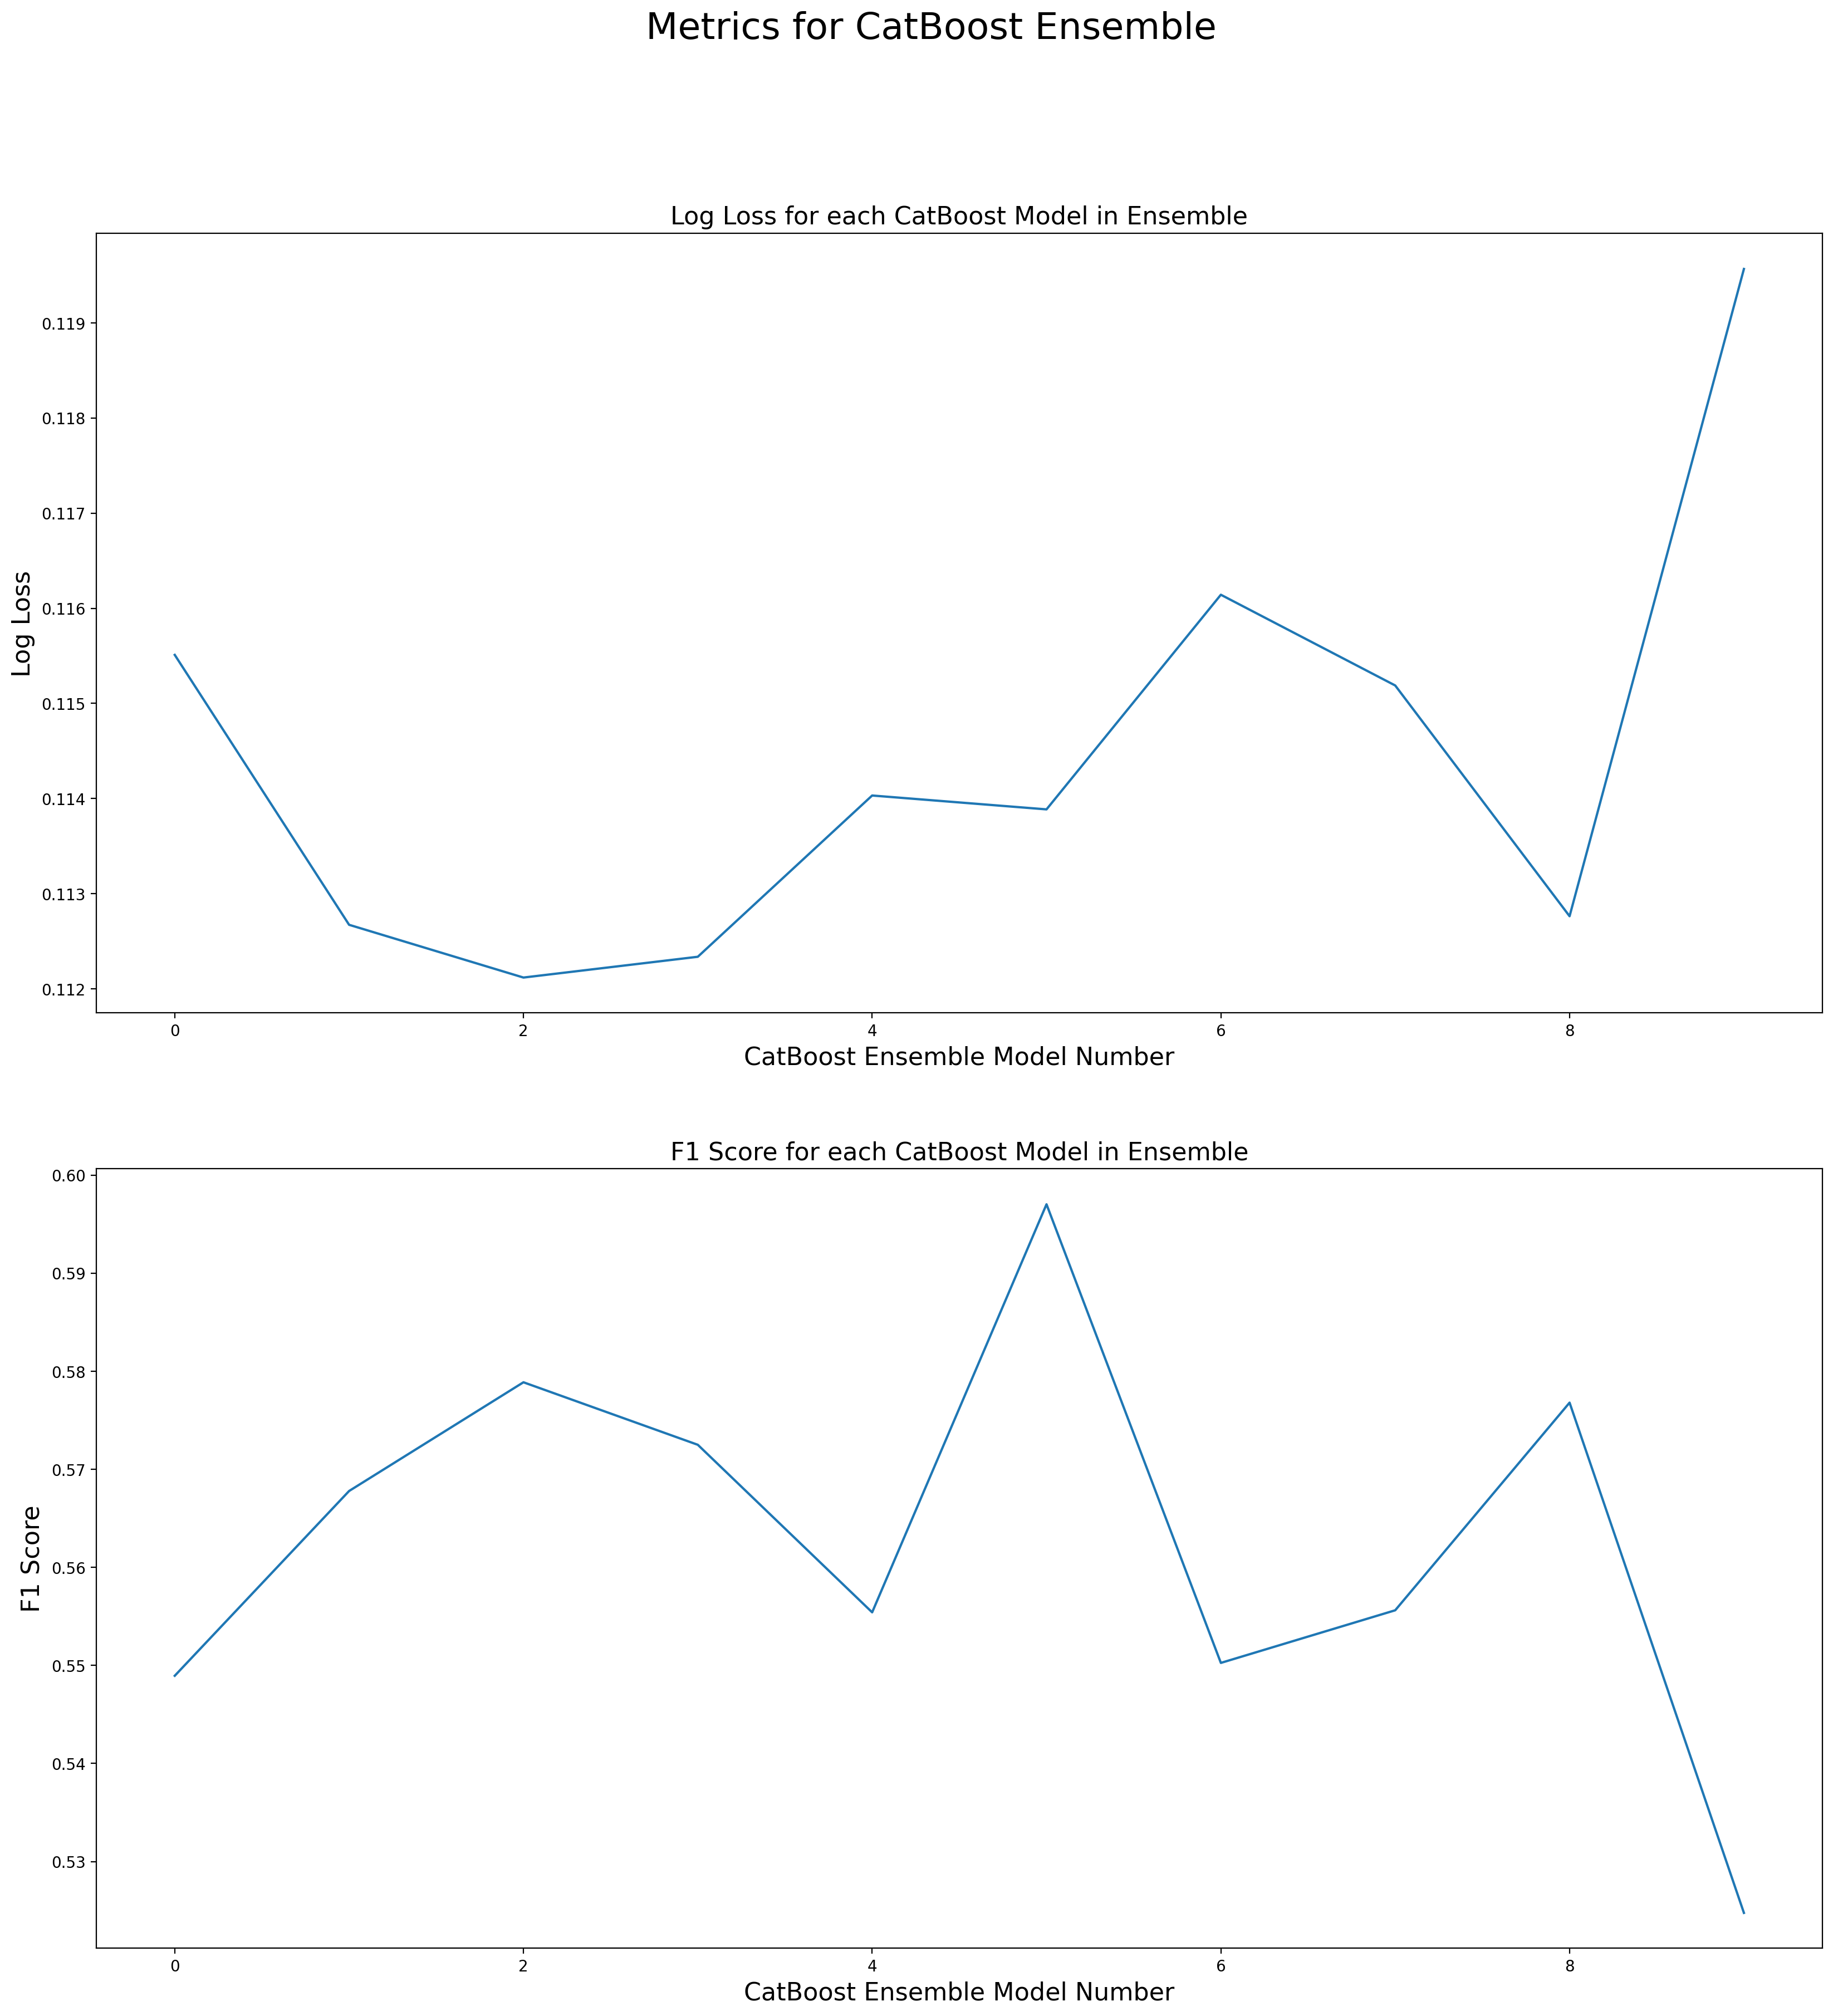

In [89]:
fig, axs = plt.subplots(2,1,figsize=(20,20))
fig.suptitle('Metrics for CatBoost Ensemble',fontsize=24)

axs[0].plot(loss_cat_ensemble_valid)
axs[0].set_xlabel('CatBoost Ensemble Model Number',fontsize=16)
axs[0].set_ylabel('Log Loss',fontsize=16)
axs[0].set_title('Log Loss for each CatBoost Model in Ensemble',fontsize=16)

axs[1].plot(f1_score_cat_ensemble)
axs[1].set_xlabel('CatBoost Ensemble Model Number',fontsize=16)
axs[1].set_ylabel('F1 Score',fontsize=16)
axs[1].set_title('F1 Score for each CatBoost Model in Ensemble',fontsize=16)
plt.show()


In [90]:
print('Average Log Loss for CatBoost Ensemble Model:', np.mean(loss_cat_ensemble_valid))

Average Log Loss for CatBoost Ensemble Model: 0.11442211219832107


## 5.9 Combined Ensemble Model

In [ ]:
# Since we have all the models trained above, we can directly combine the output for them
print('Average Log Loss for Combined Ensemble Models:', np.mean(loss_cat_ensemble_valid+loss_rf_ensemble_valid))

Average Log Loss for Combined Ensemble Models: 0.11678375236068606


# 6. Model Evaluation

In [101]:
eval = pd.DataFrame({'Model':['Logistic Regression','Random Forest','CatBoost',
                        'Logistic Regression (SMOTE)','Random Forest (SMOTE)','CatBoost (SMOTE)',
                        'Ensemble (Random Forest)','Ensemble (CatBoost)', 'Ensemble Combined'],
              'valid_loss':[0.129,0.117,0.113,0.129,0.117,0.117,np.mean(loss_rf_ensemble_valid),np.mean(loss_cat_ensemble_valid),np.mean(loss_cat_ensemble_valid+loss_rf_ensemble_valid)]})

In [102]:
test_loss = []

test_loss.append(log_loss(y_test,lr.predict_proba(x_test2)[:,1]))
test_loss.append(log_loss(y_test,rf.predict_proba(x_test2)[:,1]))
test_loss.append(log_loss(y_test,cat.predict_proba(x_test)[:,1]))
test_loss.append(log_loss(y_test,lr_smote.predict_proba(x_test2)[:,1]))
test_loss.append(log_loss(y_test,rf_smote.predict_proba(x_test2)[:,1]))
test_loss.append(log_loss(y_test,cat_smote.predict_proba(x_test2)[:,1]))
test_loss.append(log_loss(y_test,probabs_rf_ensemble_test.mean(axis=1)))
test_loss.append(log_loss(y_test,probabs_cat_ensemble_test.mean(axis=1)))
test_loss.append(log_loss(y_test,(probabs_rf_ensemble_test+probabs_cat_ensemble_test).mean(axis=1)))

eval['test_loss'] = test_loss

In [103]:
valid_f1_score = []
valid_f1_score.append(f1_score(y_val,lr.predict(x_val2)))
valid_f1_score.append(f1_score(y_val,rf.predict(x_val2)))
valid_f1_score.append(f1_score(y_val,cat.predict(x_val)))
valid_f1_score.append(f1_score(y_val,lr_smote.predict(x_val2)))
valid_f1_score.append(f1_score(y_val,rf_smote.predict(x_val2)))
valid_f1_score.append(f1_score(y_val,cat_smote.predict(x_val2)))
valid_f1_score.append(np.mean(f1_score_rf_ensemble))
valid_f1_score.append(np.mean(f1_score_cat_ensemble))
valid_f1_score.append(np.mean(f1_score_rf_ensemble+f1_score_cat_ensemble))

eval['valid_f1_score'] = valid_f1_score

In [104]:
test_f1_score = []
test_f1_score.append(f1_score(y_test,lr.predict(x_test2)))
test_f1_score.append(f1_score(y_test,rf.predict(x_test2)))
test_f1_score.append(f1_score(y_test,cat.predict(x_test)))
test_f1_score.append(f1_score(y_test,lr_smote.predict(x_test2)))
test_f1_score.append(f1_score(y_test,rf_smote.predict(x_test2)))
test_f1_score.append(f1_score(y_test,cat_smote.predict(x_test2)))
test_f1_score.append(f1_score(y_test,create_predictions(probabs_rf_ensemble_test)))
test_f1_score.append(f1_score(y_test,create_predictions(probabs_cat_ensemble_test)))
test_f1_score.append(f1_score(y_test,create_predictions(probabs_rf_ensemble_test+probabs_cat_ensemble_test)))

eval['test_f1_score'] = test_f1_score

In [105]:
eval

,Model,valid_loss,test_loss,valid_f1_score,test_f1_score
0,Logistic Regression,0.129000,0.130201,0.461708,0.443950
1,Random Forest,0.117000,0.117200,0.525166,0.529992
2,CatBoost,0.113000,0.112668,0.557604,0.568643
3,Logistic Regression (SMOTE),0.129000,0.309624,0.434018,0.434738
4,Random Forest (SMOTE),0.117000,0.134429,0.539054,0.544218
5,CatBoost (SMOTE),0.117000,0.116027,0.573012,0.574416
6,Ensemble (Random Forest),0.119145,0.116191,0.528185,0.533865
7,Ensemble (CatBoost),0.114422,0.111325,0.562801,0.577346
8,Ensemble Combined,0.116784,0.378646,0.545493,0.620178


Based on the evaluation data above, we can see that our ensemble model performs the best. If we were to base our parameters directly on the best validation log loss we would likely overfit and not perform as well in production. Using an ensemble reduces the testing scores a bit but tends to perform better in production because it uses multiple models trained on different subsets of data.

F1 score is used as the metric since we have an imbalanced dataset. This would give us a clearer picture considering both the classes and would not reward the model for choosing the majority class

# 7. Saving the Model

In [117]:
i = 0
for m in models_cat_ensemble:
    with open('models/catboost_model'+str(i)+'.pkl', 'wb') as f:
        pickle.dump(m, f)
    i += 1

i = 0
for m in models_rf_ensemble:
    with open('models/random_forest_model'+str(i)+'.pkl', 'wb') as f:
        pickle.dump(m, f)
    i += 1


# 8. Simple Sanity Check - Can be ignored

Checking to see if any child has a salary over 50K

In [107]:
tmp = create_predictions(probabs_rf_ensemble_test+probabs_cat_ensemble_test)
tmp2 = x_test.copy()

In [108]:
tmp2['pred'] = tmp

In [114]:
tmp2[['age','pred']].groupby('age').sum().reset_index().sort_values(by='age')[:20]

,age,pred
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0
